# PSI Spike 多模型对比 + Stacking Ensemble

对比 XGBoost / LightGBM / CatBoost / BalancedRandomForest 四种算法，最终用 Stacking 融合。

**Pipeline**: 数据加载 → 标签构造 → Session-aware 分割 → 4 模型独立训练+Optuna调参 → Stacking Ensemble → 统一评估

Spike 定义: `future_1s_some > 100,000 μs` (100ms)

In [18]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score, f1_score
)
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression
import optuna
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 中文字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

SEED = 42
np.random.seed(SEED)
print("Dependencies loaded.")

Dependencies loaded.


In [2]:
# ==================== 数据加载 + 标签构造 ====================
df = pd.read_csv("../processed_data/processed_psi_douyin.csv")

THRESHOLD = 100_000  # 100ms = 100,000 μs
df['is_spike'] = (df['future_1s_some'] > THRESHOLD).astype(int)

print(f"数据: {len(df)} 行, {len(df.columns)} 列")
print(f"Sessions: {df['source_file'].nunique()} 个")
print(f"\nSpike 阈值: {THRESHOLD:,} μs (100ms)")
print(f"正样本 (spike=1): {df['is_spike'].sum()} ({df['is_spike'].mean():.2%})")
print(f"负样本 (spike=0): {(1 - df['is_spike']).sum()} ({1 - df['is_spike'].mean():.2%})")
print(f"\n各 session spike 比例:")
print(df.groupby('source_file')['is_spike'].mean().round(4))

数据: 4683 行, 47 列
Sessions: 4 个

Spike 阈值: 100,000 μs (100ms)
正样本 (spike=1): 462 (9.87%)
负样本 (spike=0): 4221 (90.13%)

各 session spike 比例:
source_file
psi_douyin_20260228_211328.csv    0.1093
psi_douyin_20260228_213146.csv    0.1193
psi_douyin_20260228_215103.csv    0.0836
psi_douyin_20260228_221442.csv    0.0841
Name: is_spike, dtype: float64


In [3]:
# ==================== Session-aware 分割 ====================
sessions = df['source_file'].unique()
test_session = sessions[-1]
print(f"Test session: {test_session}")

train_df = df[df['source_file'] != test_session].reset_index(drop=True)
test_df  = df[df['source_file'] == test_session].reset_index(drop=True)

drop_cols = ['source_file', 'future_1s_some', 'future_1s_full', 'is_spike']
feature_cols = [c for c in df.columns if c not in drop_cols]

X_train = train_df[feature_cols]
y_train = train_df['is_spike']
X_test  = test_df[feature_cols]
y_test  = test_df['is_spike']

train_groups = train_df['source_file'].values

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

print(f"\nTrain: {len(X_train)} 行 (spike={y_train.sum()}, {y_train.mean():.2%})")
print(f"Test:  {len(X_test)} 行 (spike={y_test.sum()}, {y_test.mean():.2%})")
print(f"特征数: {len(feature_cols)}")
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

Test session: psi_douyin_20260228_221442.csv

Train: 3458 行 (spike=359, 10.38%)
Test:  1225 行 (spike=103, 8.41%)
特征数: 43
scale_pos_weight: 8.63


In [4]:
# ==================== 通用 Optuna CV 框架 ====================
N_TRIALS = 60
N_SPLITS = 3  # 3 个训练 session → 3-fold GroupKFold

def cv_evaluate(model_fn, X, y, groups, n_splits=N_SPLITS):
    """GroupKFold CV, 返回平均 PR-AUC"""
    gkf = GroupKFold(n_splits=n_splits)
    scores = []
    for tr_idx, va_idx in gkf.split(X, y, groups=groups):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
        model = model_fn()
        # 根据模型类型适配 fit
        if isinstance(model, xgb.XGBClassifier):
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)
        elif isinstance(model, lgb.LGBMClassifier):
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)])
        elif isinstance(model, CatBoostClassifier):
            model.fit(X_tr, y_tr, eval_set=(X_va, y_va), verbose=False)
        else:
            model.fit(X_tr, y_tr)
        y_prob = model.predict_proba(X_va)[:, 1]
        scores.append(average_precision_score(y_va, y_prob))
    return np.mean(scores)

print(f"Optuna: {N_TRIALS} trials per model, {N_SPLITS}-fold GroupKFold")

Optuna: 60 trials per model, 3-fold GroupKFold


In [5]:
# ==================== 1. XGBoost 调参 ====================
print("="*50)
print("Tuning XGBoost ...")
print("="*50)

def xgb_objective(trial):
    def model_fn():
        return xgb.XGBClassifier(
            n_estimators=500,
            max_depth=trial.suggest_int('max_depth', 3, 6),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
            subsample=trial.suggest_float('subsample', 0.6, 0.9),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 0.9),
            reg_alpha=trial.suggest_float('reg_alpha', 1e-3, 10, log=True),
            reg_lambda=trial.suggest_float('reg_lambda', 1e-3, 10, log=True),
            min_child_weight=trial.suggest_int('min_child_weight', 1, 20),
            gamma=trial.suggest_float('gamma', 0, 5),
            scale_pos_weight=trial.suggest_float('scale_pos_weight', 1, scale_pos_weight * 1.5),
            eval_metric='aucpr',
            early_stopping_rounds=30,
            random_state=SEED,
        )
    return cv_evaluate(model_fn, X_train, y_train, train_groups)

study_xgb = optuna.create_study(direction='maximize', study_name='xgb')
study_xgb.optimize(xgb_objective, n_trials=N_TRIALS, show_progress_bar=True)
print(f"\nXGBoost 最优 CV PR-AUC: {study_xgb.best_value:.4f}")
print(f"最优参数: {study_xgb.best_params}")

Tuning XGBoost ...


Best trial: 55. Best value: 0.543283: 100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


XGBoost 最优 CV PR-AUC: 0.5433
最优参数: {'max_depth': 4, 'learning_rate': 0.09399623514677957, 'subsample': 0.8067942203869204, 'colsample_bytree': 0.5140010313305408, 'reg_alpha': 0.15996118170813833, 'reg_lambda': 0.011370877355659269, 'min_child_weight': 8, 'gamma': 2.725767796147393, 'scale_pos_weight': 3.4888658280687146}


In [6]:
# ==================== 2. LightGBM 调参 ====================
print("="*50)
print("Tuning LightGBM ...")
print("="*50)

def lgbm_objective(trial):
    def model_fn():
        return lgb.LGBMClassifier(
            n_estimators=500,
            max_depth=trial.suggest_int('max_depth', 3, 8),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
            num_leaves=trial.suggest_int('num_leaves', 15, 63),
            subsample=trial.suggest_float('subsample', 0.6, 0.9),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 0.9),
            reg_alpha=trial.suggest_float('reg_alpha', 1e-3, 10, log=True),
            reg_lambda=trial.suggest_float('reg_lambda', 1e-3, 10, log=True),
            min_child_samples=trial.suggest_int('min_child_samples', 5, 50),
            scale_pos_weight=trial.suggest_float('scale_pos_weight', 1, scale_pos_weight * 1.5),
            metric='average_precision',
            n_jobs=-1,
            verbosity=-1,
            random_state=SEED,
            callbacks=[lgb.early_stopping(30, verbose=False)],
        )
    return cv_evaluate(model_fn, X_train, y_train, train_groups)

study_lgbm = optuna.create_study(direction='maximize', study_name='lgbm')
study_lgbm.optimize(lgbm_objective, n_trials=N_TRIALS, show_progress_bar=True)
print(f"\nLightGBM 最优 CV PR-AUC: {study_lgbm.best_value:.4f}")
print(f"最优参数: {study_lgbm.best_params}")

Tuning LightGBM ...


Best trial: 59. Best value: 0.530073: 100%|██████████| 60/60 [04:26<00:00,  4.44s/it]


LightGBM 最优 CV PR-AUC: 0.5301
最优参数: {'max_depth': 5, 'learning_rate': 0.011451975664616965, 'num_leaves': 38, 'subsample': 0.6708181120746479, 'colsample_bytree': 0.6507520009401526, 'reg_alpha': 0.07975363668002589, 'reg_lambda': 1.7854822108498898, 'min_child_samples': 34, 'scale_pos_weight': 6.885329830221057}


In [7]:
# ==================== 3. CatBoost 调参 ====================
print("="*50)
print("Tuning CatBoost ...")
print("="*50)

def catboost_objective(trial):
    def model_fn():
        return CatBoostClassifier(
            iterations=500,
            depth=trial.suggest_int('depth', 3, 8),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
            l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 1e-2, 10, log=True),
            subsample=trial.suggest_float('subsample', 0.6, 0.9),
            colsample_bylevel=trial.suggest_float('colsample_bylevel', 0.5, 0.9),
            min_data_in_leaf=trial.suggest_int('min_data_in_leaf', 5, 50),
            scale_pos_weight=trial.suggest_float('scale_pos_weight', 1, scale_pos_weight * 1.5),
            eval_metric='PRAUC',
            early_stopping_rounds=30,
            random_seed=SEED,
            verbose=0,
        )
    return cv_evaluate(model_fn, X_train, y_train, train_groups)

study_cat = optuna.create_study(direction='maximize', study_name='catboost')
study_cat.optimize(catboost_objective, n_trials=N_TRIALS, show_progress_bar=True)
print(f"\nCatBoost 最优 CV PR-AUC: {study_cat.best_value:.4f}")
print(f"最优参数: {study_cat.best_params}")

Tuning CatBoost ...


Best trial: 49. Best value: 0.546061: 100%|██████████| 60/60 [01:28<00:00,  1.47s/it]


CatBoost 最优 CV PR-AUC: 0.5461
最优参数: {'depth': 6, 'learning_rate': 0.019851733401994115, 'l2_leaf_reg': 1.455922765883844, 'subsample': 0.8745024051522797, 'colsample_bylevel': 0.6159498657618021, 'min_data_in_leaf': 15, 'scale_pos_weight': 1.6709405733015532}


In [8]:
# ==================== 4. BalancedRandomForest 调参 ====================
print("="*50)
print("Tuning BalancedRandomForest ...")
print("="*50)

def brf_objective(trial):
    def model_fn():
        return BalancedRandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 200, 800),
            max_depth=trial.suggest_int('max_depth', 5, 20),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 20),
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 15),
            max_features=trial.suggest_float('max_features', 0.3, 0.9),
            sampling_strategy=trial.suggest_float('sampling_strategy', 0.5, 1.0),
            replacement=trial.suggest_categorical('replacement', [True, False]),
            n_jobs=-1,
            random_state=SEED,
        )
    return cv_evaluate(model_fn, X_train, y_train, train_groups)

study_brf = optuna.create_study(direction='maximize', study_name='brf')
study_brf.optimize(brf_objective, n_trials=N_TRIALS, show_progress_bar=True)
print(f"\nBalancedRF 最优 CV PR-AUC: {study_brf.best_value:.4f}")
print(f"最优参数: {study_brf.best_params}")

Tuning BalancedRandomForest ...


Best trial: 58. Best value: 0.528942: 100%|██████████| 60/60 [03:37<00:00,  3.62s/it]


BalancedRF 最优 CV PR-AUC: 0.5289
最优参数: {'n_estimators': 486, 'max_depth': 11, 'min_samples_split': 15, 'min_samples_leaf': 15, 'max_features': 0.3461918520930496, 'sampling_strategy': 0.509602570129657, 'replacement': False}


In [9]:
# ==================== 用最优参数训练 4 个最终模型 ====================
print("训练 4 个最终模型 ...\n")

# --- XGBoost ---
xgb_params = study_xgb.best_params.copy()
xgb_params.update({'n_estimators': 1000, 'eval_metric': 'aucpr',
                    'early_stopping_rounds': 50, 'random_state': SEED})
model_xgb = xgb.XGBClassifier(**xgb_params)
model_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
print(f"XGBoost    best_iter={model_xgb.best_iteration}, test_pr_auc={model_xgb.best_score:.4f}")

# --- LightGBM ---
lgbm_params = study_lgbm.best_params.copy()
lgbm_params.update({'n_estimators': 1000, 'metric': 'average_precision',
                     'n_jobs': -1, 'verbosity': -1, 'random_state': SEED})
model_lgbm = lgb.LGBMClassifier(
    **lgbm_params,
    callbacks=[lgb.early_stopping(50, verbose=False)]
)
model_lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)])
print(f"LightGBM   best_iter={model_lgbm.best_iteration_}, test_pr_auc={model_lgbm.best_score_['valid_0']['average_precision']:.4f}")

# --- CatBoost ---
cat_params = study_cat.best_params.copy()
cat_params.update({'iterations': 1000, 'eval_metric': 'PRAUC',
                    'early_stopping_rounds': 50, 'random_seed': SEED, 'verbose': 0})
model_cat = CatBoostClassifier(**cat_params)
model_cat.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0)
print(f"CatBoost   best_iter={model_cat.best_iteration_}, test_pr_auc={model_cat.best_score_['validation']['PRAUC']:.4f}")

# --- BalancedRandomForest ---
brf_params = study_brf.best_params.copy()
brf_params.update({'n_jobs': -1, 'random_state': SEED})
model_brf = BalancedRandomForestClassifier(**brf_params)
model_brf.fit(X_train, y_train)
brf_prob = model_brf.predict_proba(X_test)[:, 1]
print(f"BalancedRF test_pr_auc={average_precision_score(y_test, brf_prob):.4f}")

训练 4 个最终模型 ...

XGBoost    best_iter=59, test_pr_auc=0.5201
LightGBM   best_iter=0, test_pr_auc=0.4944
CatBoost   best_iter=392, test_pr_auc=0.6027
BalancedRF test_pr_auc=0.4934


In [10]:
# ==================== 单模型评估汇总 ====================
models = {
    'XGBoost':    model_xgb,
    'LightGBM':   model_lgbm,
    'CatBoost':   model_cat,
    'BalancedRF': model_brf,
}

results = {}
for name, model in models.items():
    prob = model.predict_proba(X_test)[:, 1]
    pr_auc = average_precision_score(y_test, prob)
    roc_auc = roc_auc_score(y_test, prob)
    # 最优 F1 阈值
    precs, recs, thrs = precision_recall_curve(y_test, prob)
    f1s = 2 * precs * recs / (precs + recs + 1e-8)
    best_i = np.argmax(f1s)
    best_thr = thrs[best_i]
    pred = (prob >= best_thr).astype(int)
    f1 = f1_score(y_test, pred)
    results[name] = {
        'prob': prob, 'pr_auc': pr_auc, 'roc_auc': roc_auc,
        'f1': f1, 'threshold': best_thr,
        'precision': precs[best_i], 'recall': recs[best_i],
        'pred': pred,
    }

# 打表
print(f"{'Model':<16} {'PR-AUC':>8} {'ROC-AUC':>9} {'F1':>6} {'Prec':>6} {'Rec':>6} {'Thr':>6}")
print("-" * 65)
for name, r in results.items():
    print(f"{name:<16} {r['pr_auc']:>8.4f} {r['roc_auc']:>9.4f} {r['f1']:>6.4f} {r['precision']:>6.4f} {r['recall']:>6.4f} {r['threshold']:>6.4f}")

Model              PR-AUC   ROC-AUC     F1   Prec    Rec    Thr
-----------------------------------------------------------------
XGBoost            0.5217    0.8252 0.5612 0.5914 0.5340 0.5550
LightGBM           0.4944    0.8274 0.5437 0.5437 0.5437 0.5946
CatBoost           0.5199    0.8313 0.5628 0.5833 0.5437 0.3754
BalancedRF         0.4934    0.8219 0.5377 0.5229 0.5534 0.5702


In [11]:
# ==================== Stacking Ensemble ====================
# 第一层：4 个基模型的 OOF 概率作为特征
# 第二层：LogisticRegression 元学习器
print("构建 Stacking Ensemble ...\n")

# 1. 生成 OOF 概率（训练集）
gkf = GroupKFold(n_splits=N_SPLITS)
oof_probs = {name: np.zeros(len(X_train)) for name in models}
test_probs_folds = {name: [] for name in models}

for fold_idx, (tr_idx, va_idx) in enumerate(gkf.split(X_train, y_train, groups=train_groups)):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
    print(f"  Fold {fold_idx+1}/{N_SPLITS} ...")

    # XGBoost
    m = xgb.XGBClassifier(**{**study_xgb.best_params, 'n_estimators': 1000,
                             'eval_metric': 'aucpr', 'early_stopping_rounds': 50, 'random_state': SEED})
    m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)
    oof_probs['XGBoost'][va_idx] = m.predict_proba(X_va)[:, 1]
    test_probs_folds['XGBoost'].append(m.predict_proba(X_test)[:, 1])

    # LightGBM
    m = lgb.LGBMClassifier(**{**study_lgbm.best_params, 'n_estimators': 1000,
                              'metric': 'average_precision', 'n_jobs': -1, 'verbosity': -1, 'random_state': SEED},
                           callbacks=[lgb.early_stopping(50, verbose=False)])
    m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)])
    oof_probs['LightGBM'][va_idx] = m.predict_proba(X_va)[:, 1]
    test_probs_folds['LightGBM'].append(m.predict_proba(X_test)[:, 1])

    # CatBoost
    m = CatBoostClassifier(**{**study_cat.best_params, 'iterations': 1000,
                              'eval_metric': 'PRAUC', 'early_stopping_rounds': 50, 'random_seed': SEED, 'verbose': 0})
    m.fit(X_tr, y_tr, eval_set=(X_va, y_va), verbose=0)
    oof_probs['CatBoost'][va_idx] = m.predict_proba(X_va)[:, 1]
    test_probs_folds['CatBoost'].append(m.predict_proba(X_test)[:, 1])

    # BalancedRF
    m = BalancedRandomForestClassifier(**{**study_brf.best_params, 'n_jobs': -1, 'random_state': SEED})
    m.fit(X_tr, y_tr)
    oof_probs['BalancedRF'][va_idx] = m.predict_proba(X_va)[:, 1]
    test_probs_folds['BalancedRF'].append(m.predict_proba(X_test)[:, 1])

# 2. 构造 meta 特征
meta_train = pd.DataFrame(oof_probs)
meta_test  = pd.DataFrame({name: np.mean(test_probs_folds[name], axis=0) for name in models})

# 3. 训练元学习器
meta_model = LogisticRegression(C=1.0, max_iter=1000, random_state=SEED)
meta_model.fit(meta_train, y_train)

# Stacking 预测
stack_prob = meta_model.predict_proba(meta_test)[:, 1]

# 4. Stacking 评估
stack_pr_auc = average_precision_score(y_test, stack_prob)
stack_roc_auc = roc_auc_score(y_test, stack_prob)
precs, recs, thrs = precision_recall_curve(y_test, stack_prob)
f1s = 2 * precs * recs / (precs + recs + 1e-8)
best_i = np.argmax(f1s)
stack_thr = thrs[best_i]
stack_pred = (stack_prob >= stack_thr).astype(int)
stack_f1 = f1_score(y_test, stack_pred)

results['Stacking'] = {
    'prob': stack_prob, 'pr_auc': stack_pr_auc, 'roc_auc': stack_roc_auc,
    'f1': stack_f1, 'threshold': stack_thr,
    'precision': precs[best_i], 'recall': recs[best_i],
    'pred': stack_pred,
}

print(f"\nStacking PR-AUC: {stack_pr_auc:.4f}, ROC-AUC: {stack_roc_auc:.4f}, F1: {stack_f1:.4f}")
print(f"Meta-learner coefficients: {dict(zip(models.keys(), meta_model.coef_[0].round(3)))}")

构建 Stacking Ensemble ...

  Fold 1/3 ...
  Fold 2/3 ...
  Fold 3/3 ...

Stacking PR-AUC: 0.4976, ROC-AUC: 0.8294, F1: 0.5566
Meta-learner coefficients: {'XGBoost': np.float64(0.668), 'LightGBM': np.float64(1.503), 'CatBoost': np.float64(0.056), 'BalancedRF': np.float64(3.198)}


In [12]:
# ==================== 最终对比汇总表 ====================
print("\n" + "=" * 70)
print(f"{'Model':<16} {'PR-AUC':>8} {'ROC-AUC':>9} {'F1':>6} {'Prec':>6} {'Rec':>6} {'Thr':>6}")
print("-" * 70)
for name, r in results.items():
    marker = " ★" if r['pr_auc'] == max(v['pr_auc'] for v in results.values()) else ""
    print(f"{name:<16} {r['pr_auc']:>8.4f} {r['roc_auc']:>9.4f} {r['f1']:>6.4f} {r['precision']:>6.4f} {r['recall']:>6.4f} {r['threshold']:>6.4f}{marker}")
print("=" * 70)
print("★ = 最高 PR-AUC")


Model              PR-AUC   ROC-AUC     F1   Prec    Rec    Thr
----------------------------------------------------------------------
XGBoost            0.5217    0.8252 0.5612 0.5914 0.5340 0.5550 ★
LightGBM           0.4944    0.8274 0.5437 0.5437 0.5437 0.5946
CatBoost           0.5199    0.8313 0.5628 0.5833 0.5437 0.3754
BalancedRF         0.4934    0.8219 0.5377 0.5229 0.5534 0.5702
Stacking           0.4976    0.8294 0.5566 0.5413 0.5728 0.2417
★ = 最高 PR-AUC


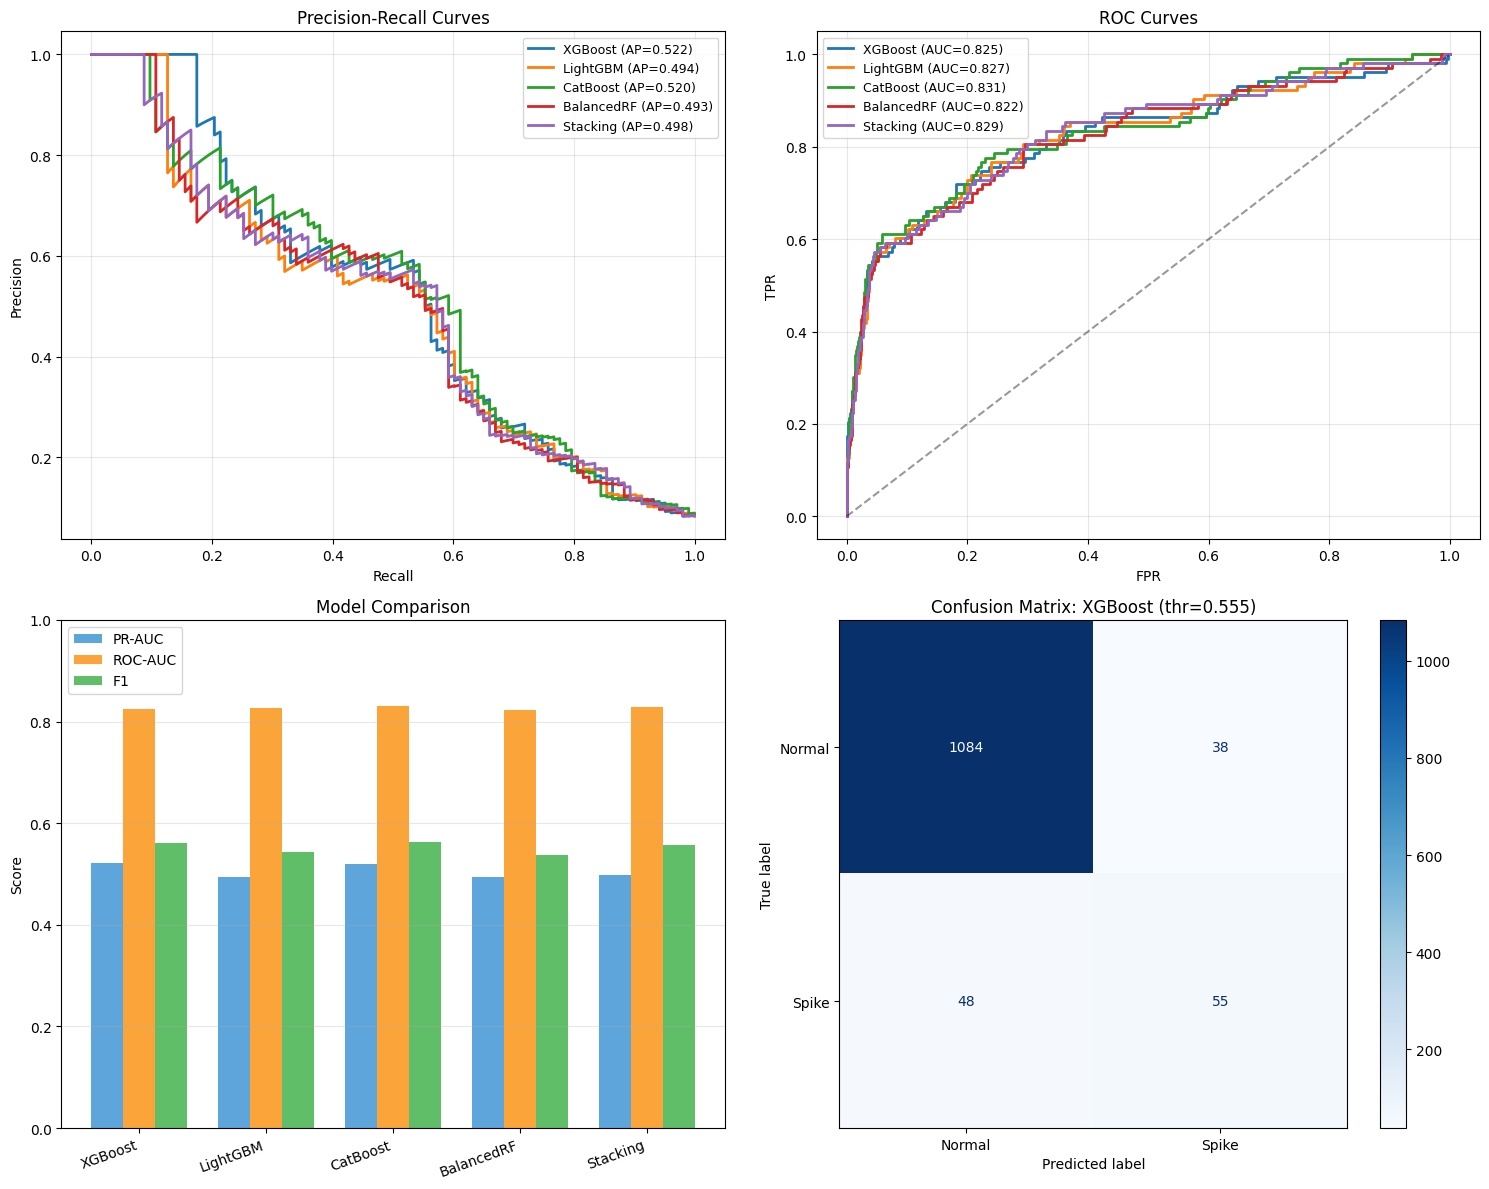

In [13]:
# ==================== 可视化 ====================
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# 1. PR 曲线对比
ax = axes[0, 0]
for i, (name, r) in enumerate(results.items()):
    precs, recs, _ = precision_recall_curve(y_test, r['prob'])
    ax.plot(recs, precs, color=colors[i], lw=2, label=f"{name} (AP={r['pr_auc']:.3f})")
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# 2. ROC 曲线对比
ax = axes[0, 1]
for i, (name, r) in enumerate(results.items()):
    fpr, tpr, _ = roc_curve(y_test, r['prob'])
    ax.plot(fpr, tpr, color=colors[i], lw=2, label=f"{name} (AUC={r['roc_auc']:.3f})")
ax.plot([0, 1], [0, 1], 'k--', alpha=0.4)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC Curves')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# 3. 柱状图对比 (PR-AUC, ROC-AUC, F1)
ax = axes[1, 0]
model_names = list(results.keys())
x = np.arange(len(model_names))
w = 0.25
pr_aucs = [results[n]['pr_auc'] for n in model_names]
roc_aucs = [results[n]['roc_auc'] for n in model_names]
f1s_bar = [results[n]['f1'] for n in model_names]

ax.bar(x - w, pr_aucs, w, label='PR-AUC', color='#5DA5DA')
ax.bar(x,     roc_aucs, w, label='ROC-AUC', color='#FAA43A')
ax.bar(x + w, f1s_bar, w, label='F1', color='#60BD68')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=20, ha='right')
ax.set_ylabel('Score')
ax.set_title('Model Comparison')
ax.legend(loc='upper left')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')

# 4. 最优模型的混淆矩阵
best_name = max(results, key=lambda n: results[n]['pr_auc'])
ax = axes[1, 1]
cm = confusion_matrix(y_test, results[best_name]['pred'])
ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Spike']).plot(ax=ax, cmap='Blues')
ax.set_title(f'Confusion Matrix: {best_name} (thr={results[best_name]["threshold"]:.3f})')

plt.tight_layout()
plt.show()

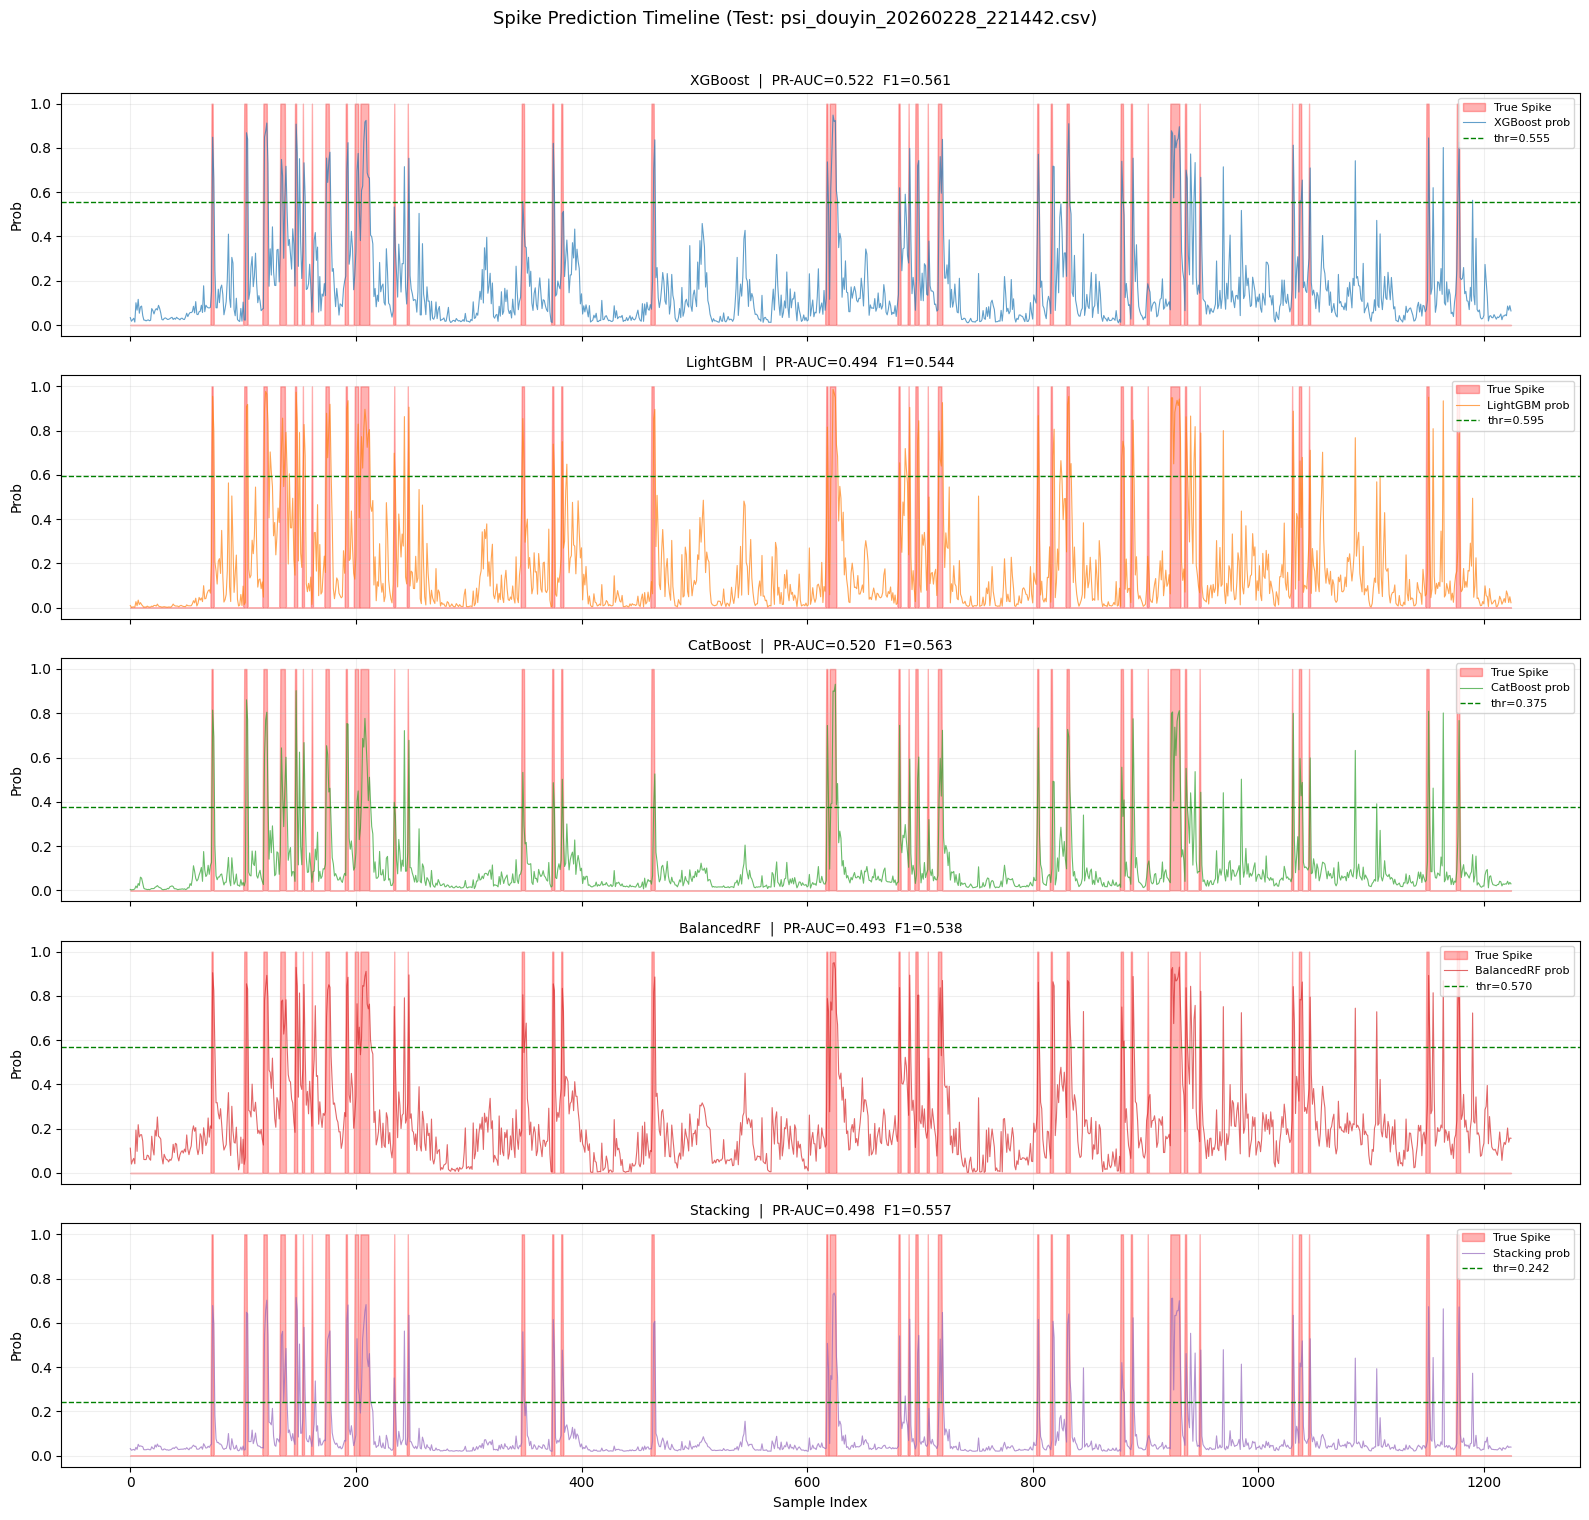

In [14]:
# ==================== 时序对比可视化 ====================
fig, axes = plt.subplots(len(results), 1, figsize=(16, 3 * len(results)), sharex=True)

for i, (name, r) in enumerate(results.items()):
    ax = axes[i]
    ax.fill_between(range(len(y_test)), y_test.values, alpha=0.3, color='red', label='True Spike')
    ax.plot(r['prob'], color=colors[i], alpha=0.7, lw=0.8, label=f'{name} prob')
    ax.axhline(r['threshold'], color='green', linestyle='--', lw=1,
               label=f"thr={r['threshold']:.3f}")
    ax.set_ylabel('Prob')
    ax.set_title(f"{name}  |  PR-AUC={r['pr_auc']:.3f}  F1={r['f1']:.3f}", fontsize=10)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.2)

axes[-1].set_xlabel('Sample Index')
fig.suptitle(f'Spike Prediction Timeline (Test: {test_session})', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

In [16]:
# ==================== 事件级评估：突破 / 恢复 / 提前预警 (全模型) ====================
TIME_PER_STEP = 0.5
LOOK_BACK = 20

true_seq = y_test.values

# ───── 识别 spike 事件 ─────
events = []
in_event = False
for i in range(len(true_seq)):
    if true_seq[i] == 1 and not in_event:
        event_start = i; in_event = True
    elif true_seq[i] == 0 and in_event:
        events.append((event_start, i - 1)); in_event = False
if in_event:
    events.append((event_start, len(true_seq) - 1))

print(f"Spike 事件数: {len(events)}, 搜索窗口: {LOOK_BACK}步 ({LOOK_BACK*TIME_PER_STEP:.0f}s)\n")

# ───── 逐模型 × 逐事件分析 ─────
model_event_stats = {}

for model_name, r in results.items():
    pred_seq = r['pred']
    prob_seq = r['prob']

    bt_exact = 0; bt_toler = 0; rc_exact = 0; rc_count = 0
    lead_cons_list = []; lead_first_list = []; prob_lead_list = []; cov_list = []

    for (start, end) in events:
        # 突破
        bt_exact += int(pred_seq[start] == 1)
        bt_range = slice(max(0, start-1), min(len(pred_seq), start+2))
        bt_toler += int(any(pred_seq[bt_range] == 1))
        # 恢复
        if end + 1 < len(pred_seq):
            rc_count += 1
            rc_exact += int(pred_seq[end+1] == 0)
        # 连续提前预警
        lc = 0
        for j in range(start-1, max(-1, start-LOOK_BACK-1), -1):
            if pred_seq[j] == 1: lc += 1
            else: break
        lead_cons_list.append(lc * TIME_PER_STEP)
        # 首信号提前预警
        ls = max(0, start - LOOK_BACK)
        first_j = next((j for j in range(ls, start) if pred_seq[j] == 1), None)
        lead_first_list.append((start - first_j) * TIME_PER_STEP if first_j is not None else 0)
        # 概率提前预警 (prob>0.5)
        prob_j = next((j for j in range(ls, start) if prob_seq[j] > 0.5), None)
        prob_lead_list.append((start - prob_j) * TIME_PER_STEP if prob_j is not None else 0)
        # 覆盖率
        cov_list.append(pred_seq[start:end+1].mean())

    n = len(events)
    has_warning = sum(1 for l in lead_first_list if l > 0)
    model_event_stats[model_name] = {
        'bt_exact': bt_exact/n, 'bt_toler': bt_toler/n,
        'rc_exact': rc_exact/rc_count if rc_count else 0,
        'has_warning_rate': has_warning/n,
        'lead_cons_avg': np.mean(lead_cons_list),
        'lead_first_avg': np.mean(lead_first_list),
        'prob_lead_avg': np.mean(prob_lead_list),
        'coverage_avg': np.mean(cov_list),
        'lead_first_max': np.max(lead_first_list),
    }

# ───── 打印对比表 ─────
print(f"{'Model':<16} {'突破(精确)':>10} {'突破(±1)':>10} {'恢复':>8} {'有预警':>8} "
      f"{'连续预警':>10} {'首信号预警':>10} {'概率预警':>10} {'覆盖率':>8}")
print("-" * 110)
for name, s in model_event_stats.items():
    print(f"{name:<16} {s['bt_exact']:>9.0%} {s['bt_toler']:>9.0%} "
          f"{s['rc_exact']:>7.0%} {s['has_warning_rate']:>7.0%} "
          f"{s['lead_cons_avg']:>8.1f}s {s['lead_first_avg']:>8.1f}s "
          f"{s['prob_lead_avg']:>8.1f}s {s['coverage_avg']:>7.0%}")
print("-" * 110)
print("突破=事件开始时模型是否检测到, 恢复=事件结束后模型是否预测0, 预警=提前多少秒预测到spike")

Spike 事件数: 38, 搜索窗口: 20步 (10s)

Model                突破(精确)     突破(±1)       恢复      有预警       连续预警      首信号预警       概率预警      覆盖率
--------------------------------------------------------------------------------------------------------------
XGBoost                 0%       68%     37%     66%      0.0s      4.1s      4.2s     38%
LightGBM                5%       68%     37%     66%      0.0s      4.2s      4.6s     41%
CatBoost                5%       71%     32%     66%      0.0s      4.1s      3.8s     42%
BalancedRF              3%       74%     18%     66%      0.1s      4.1s      4.5s     41%
Stacking                3%       74%     24%     66%      0.1s      4.2s      3.9s     43%
--------------------------------------------------------------------------------------------------------------
突破=事件开始时模型是否检测到, 恢复=事件结束后模型是否预测0, 预警=提前多少秒预测到spike


共 38 个 spike 事件，每页 4 个



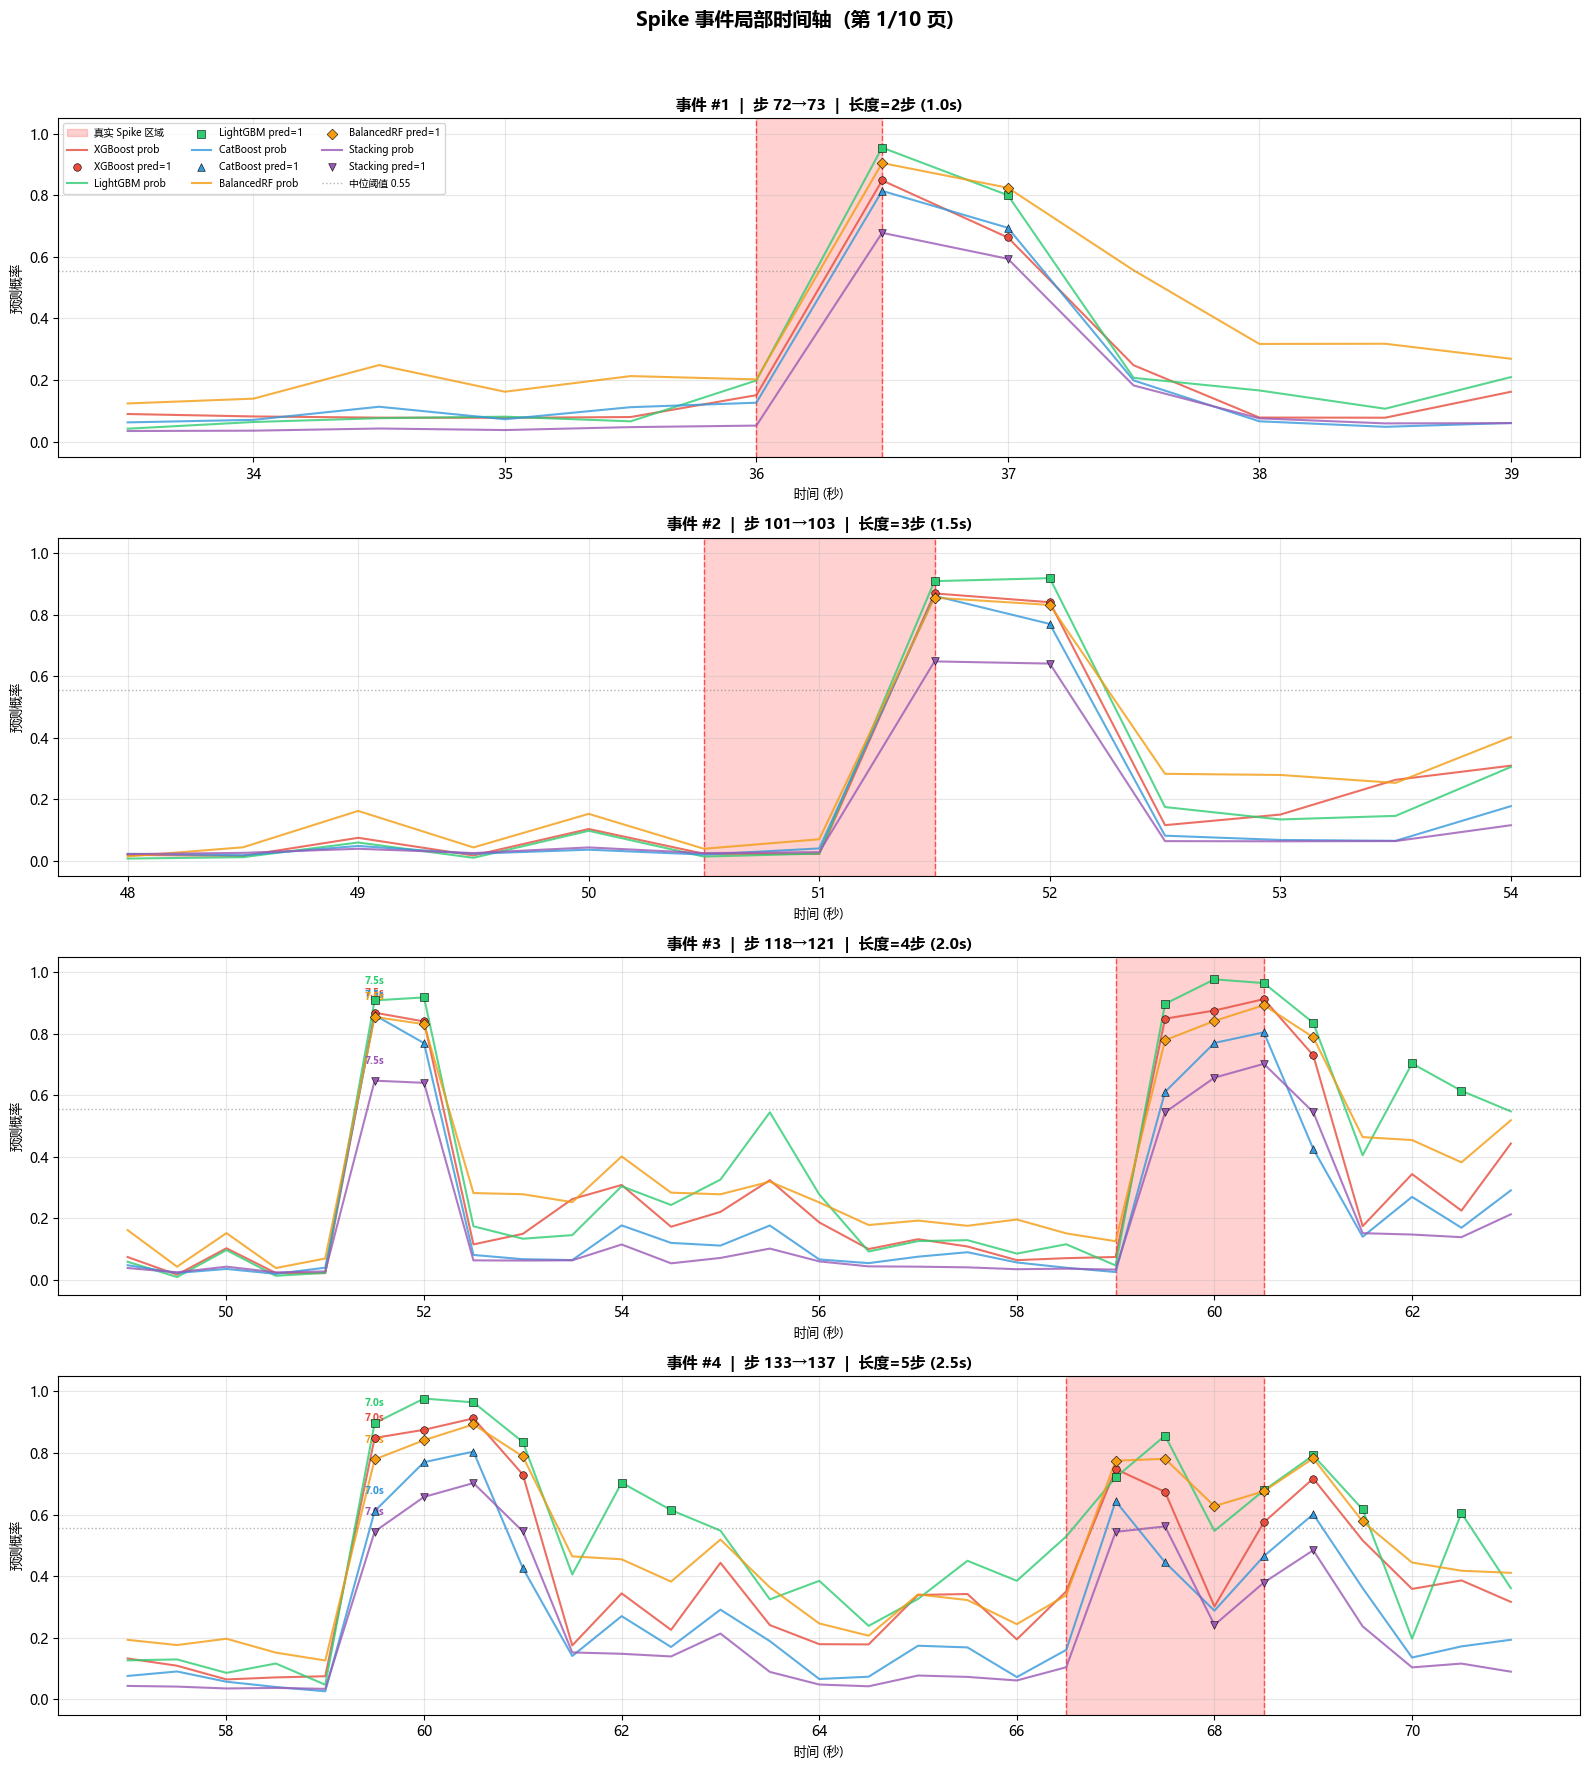

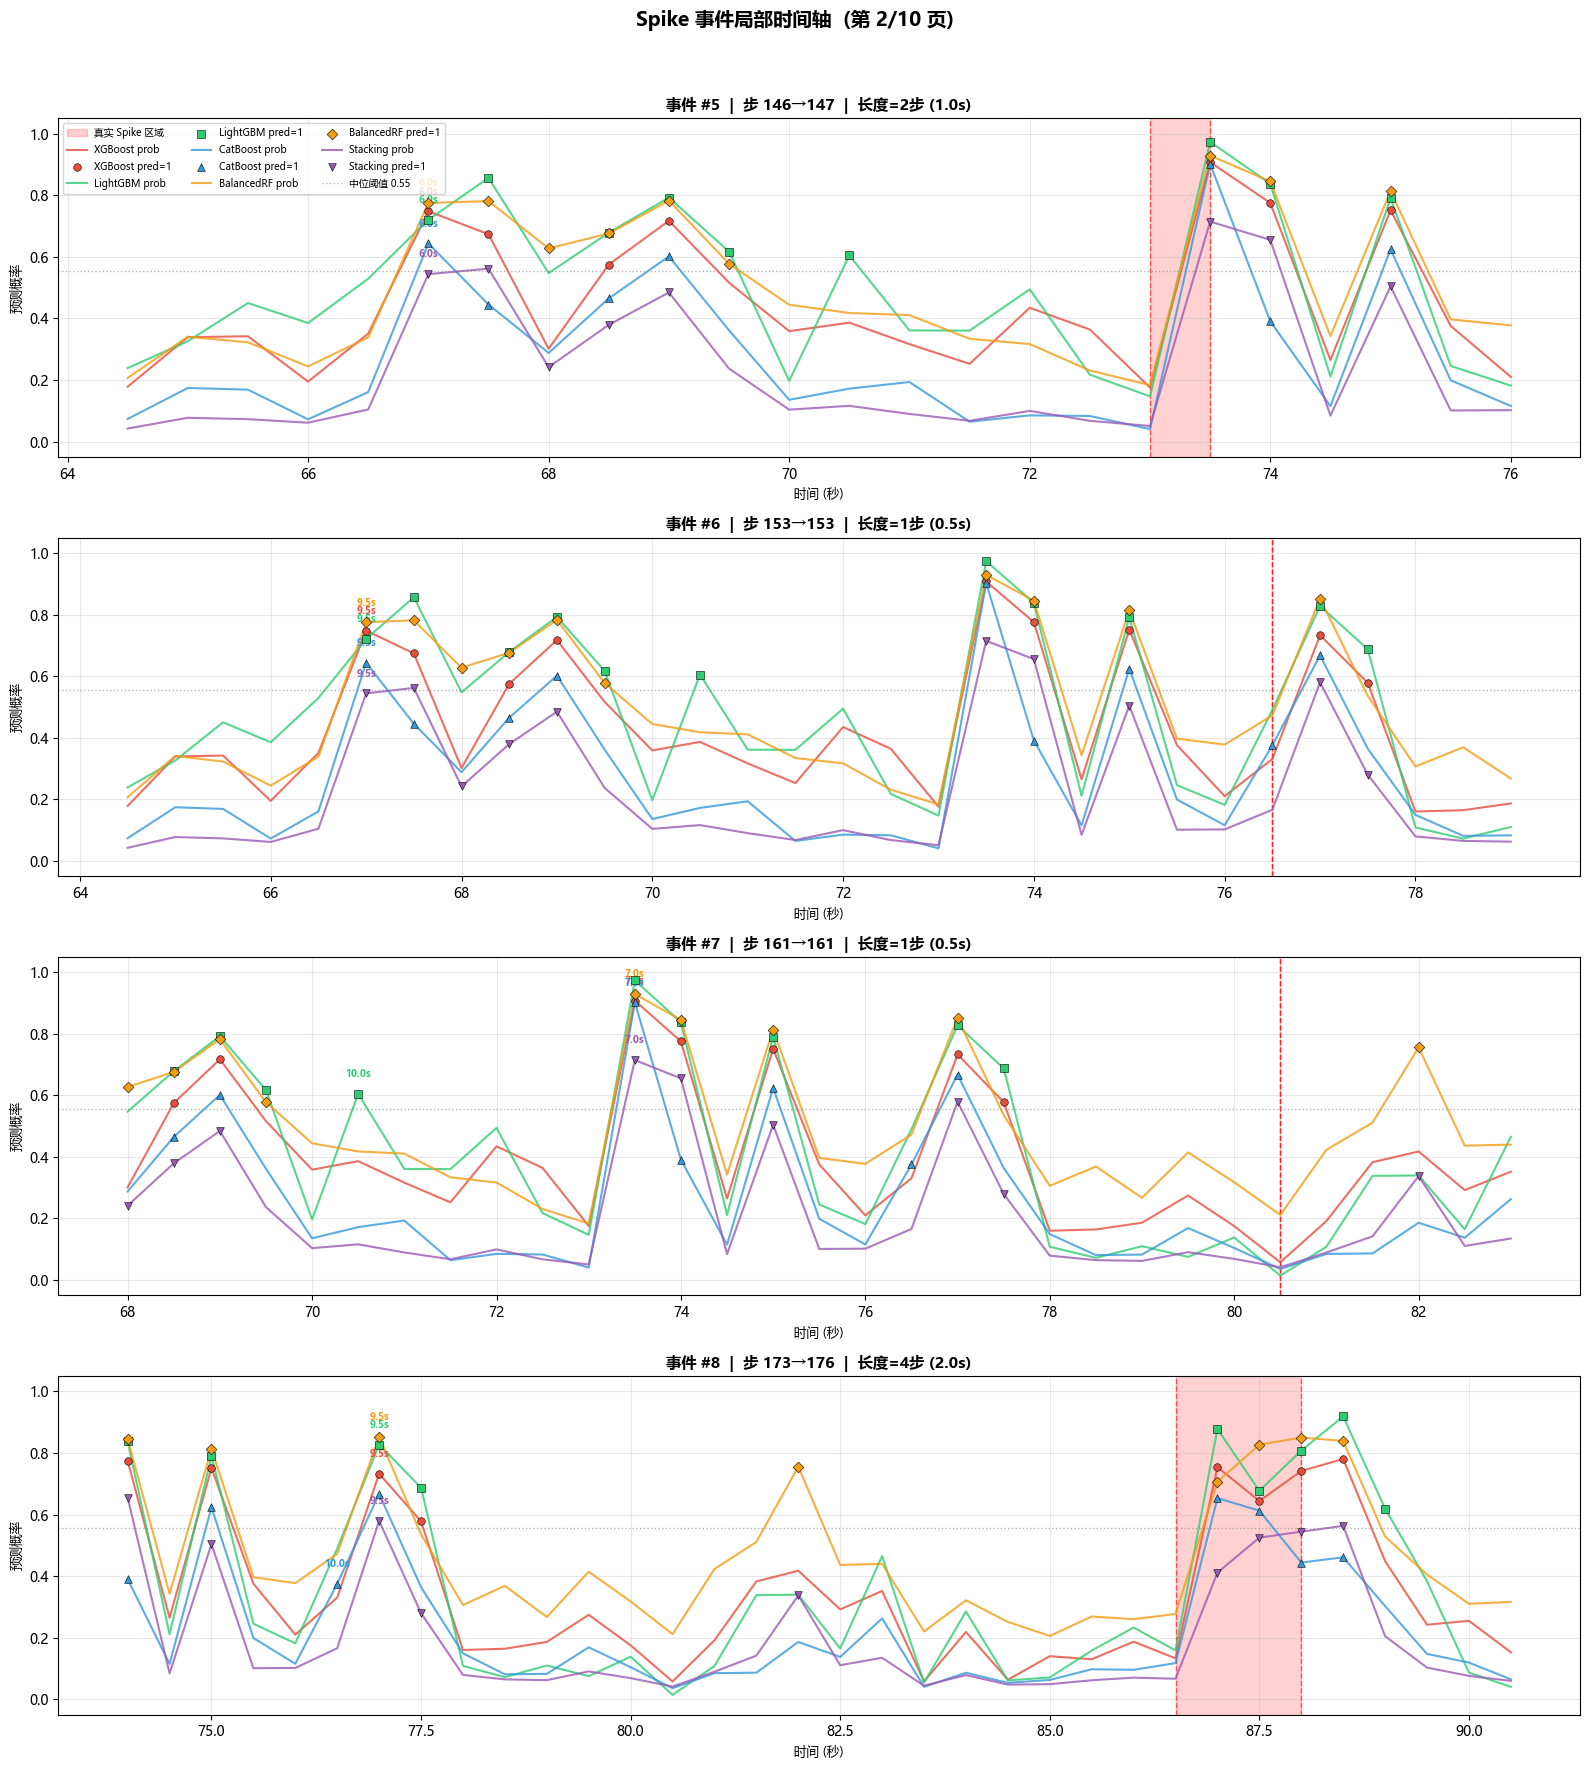

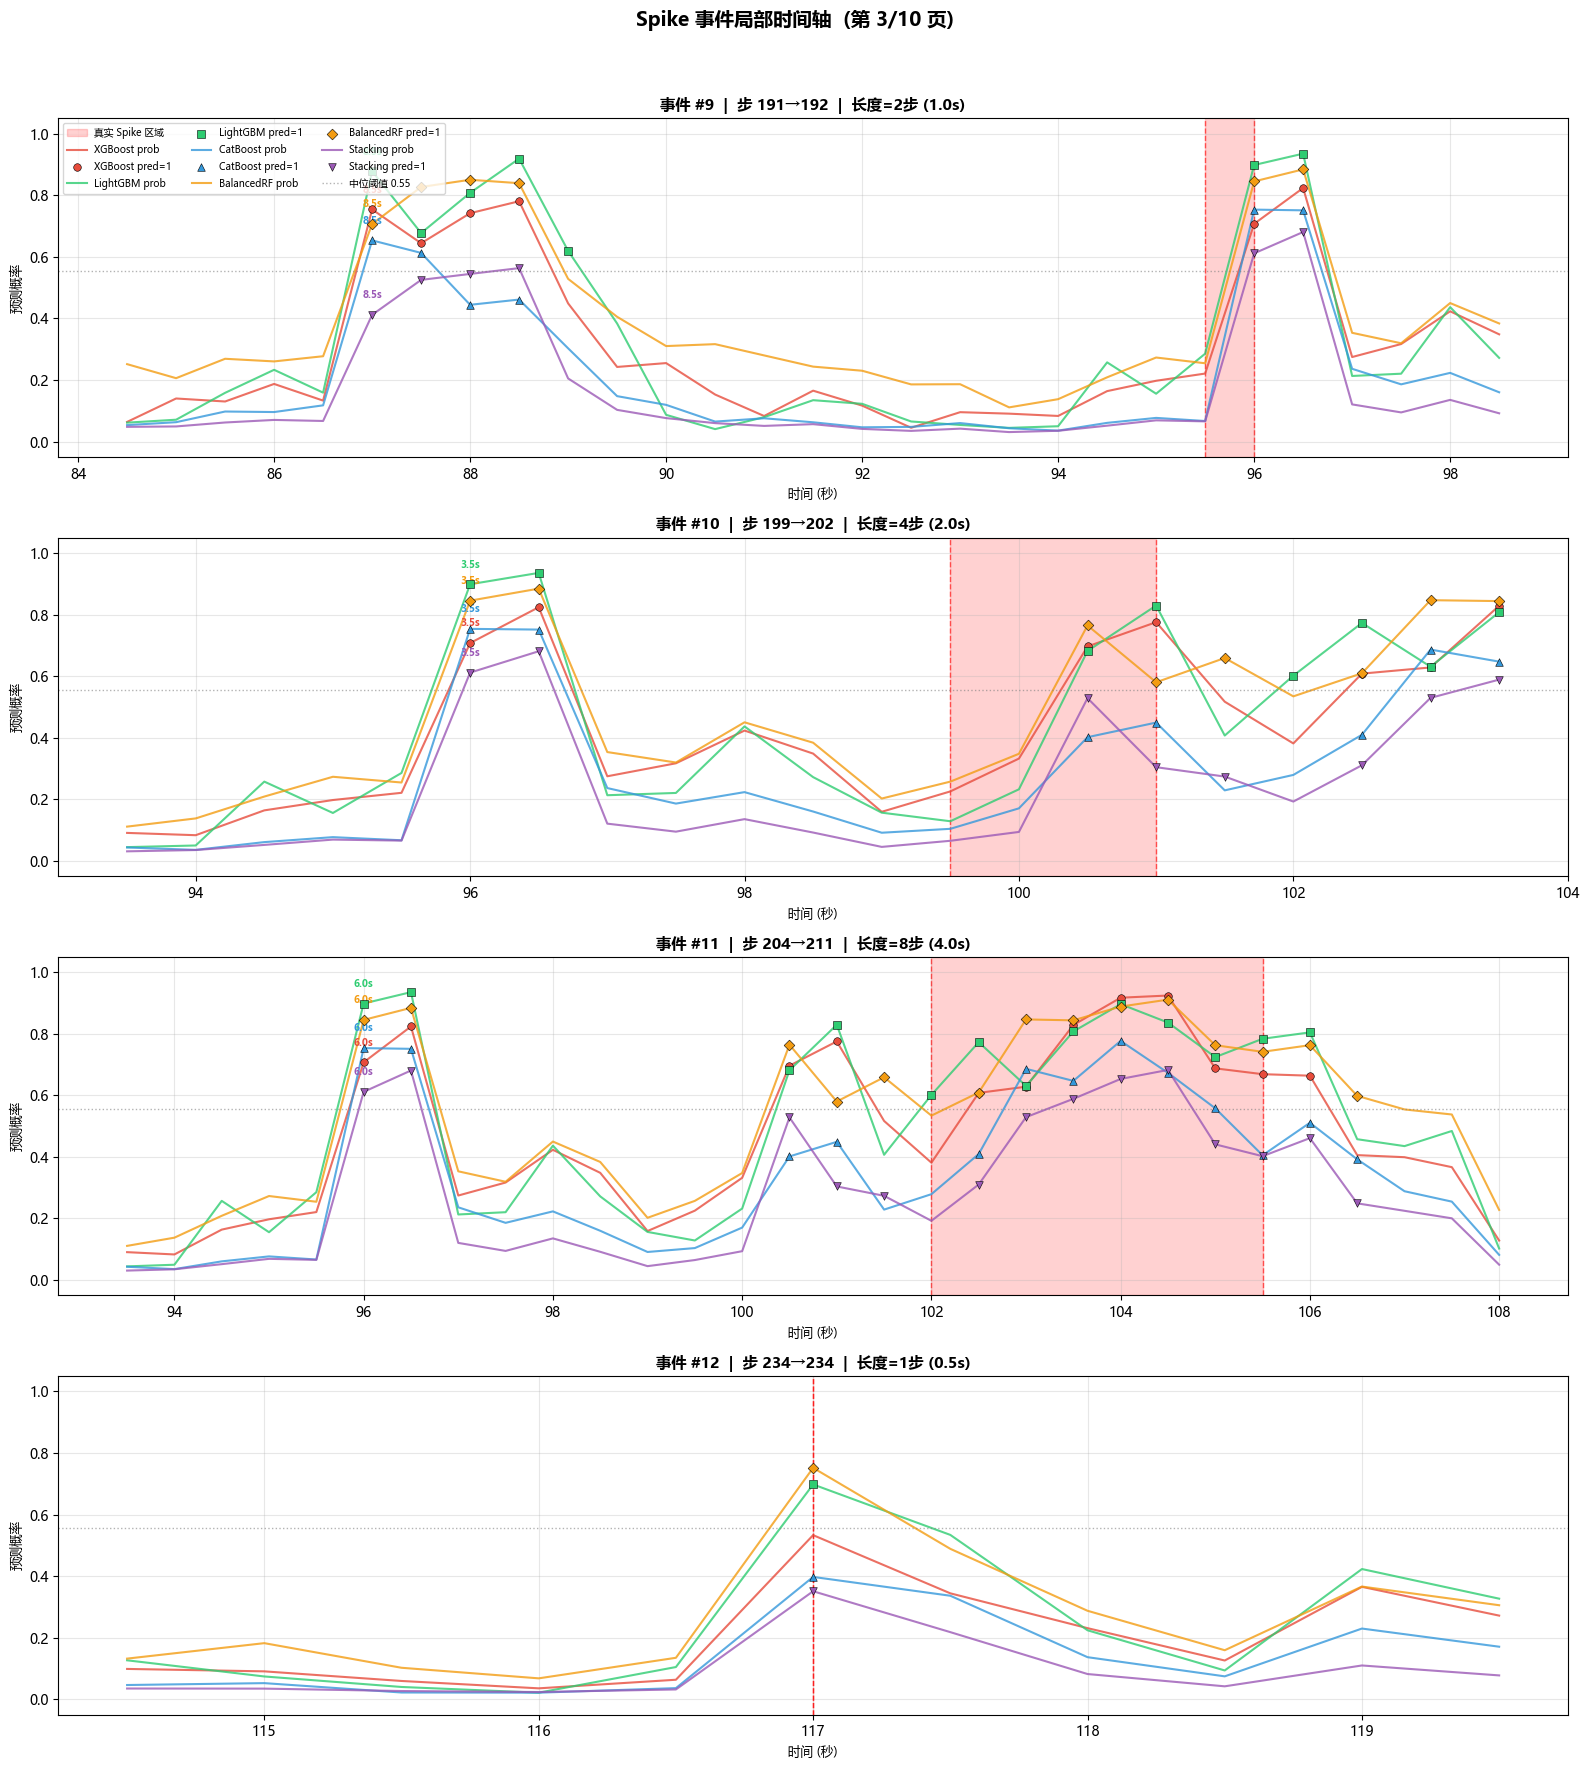

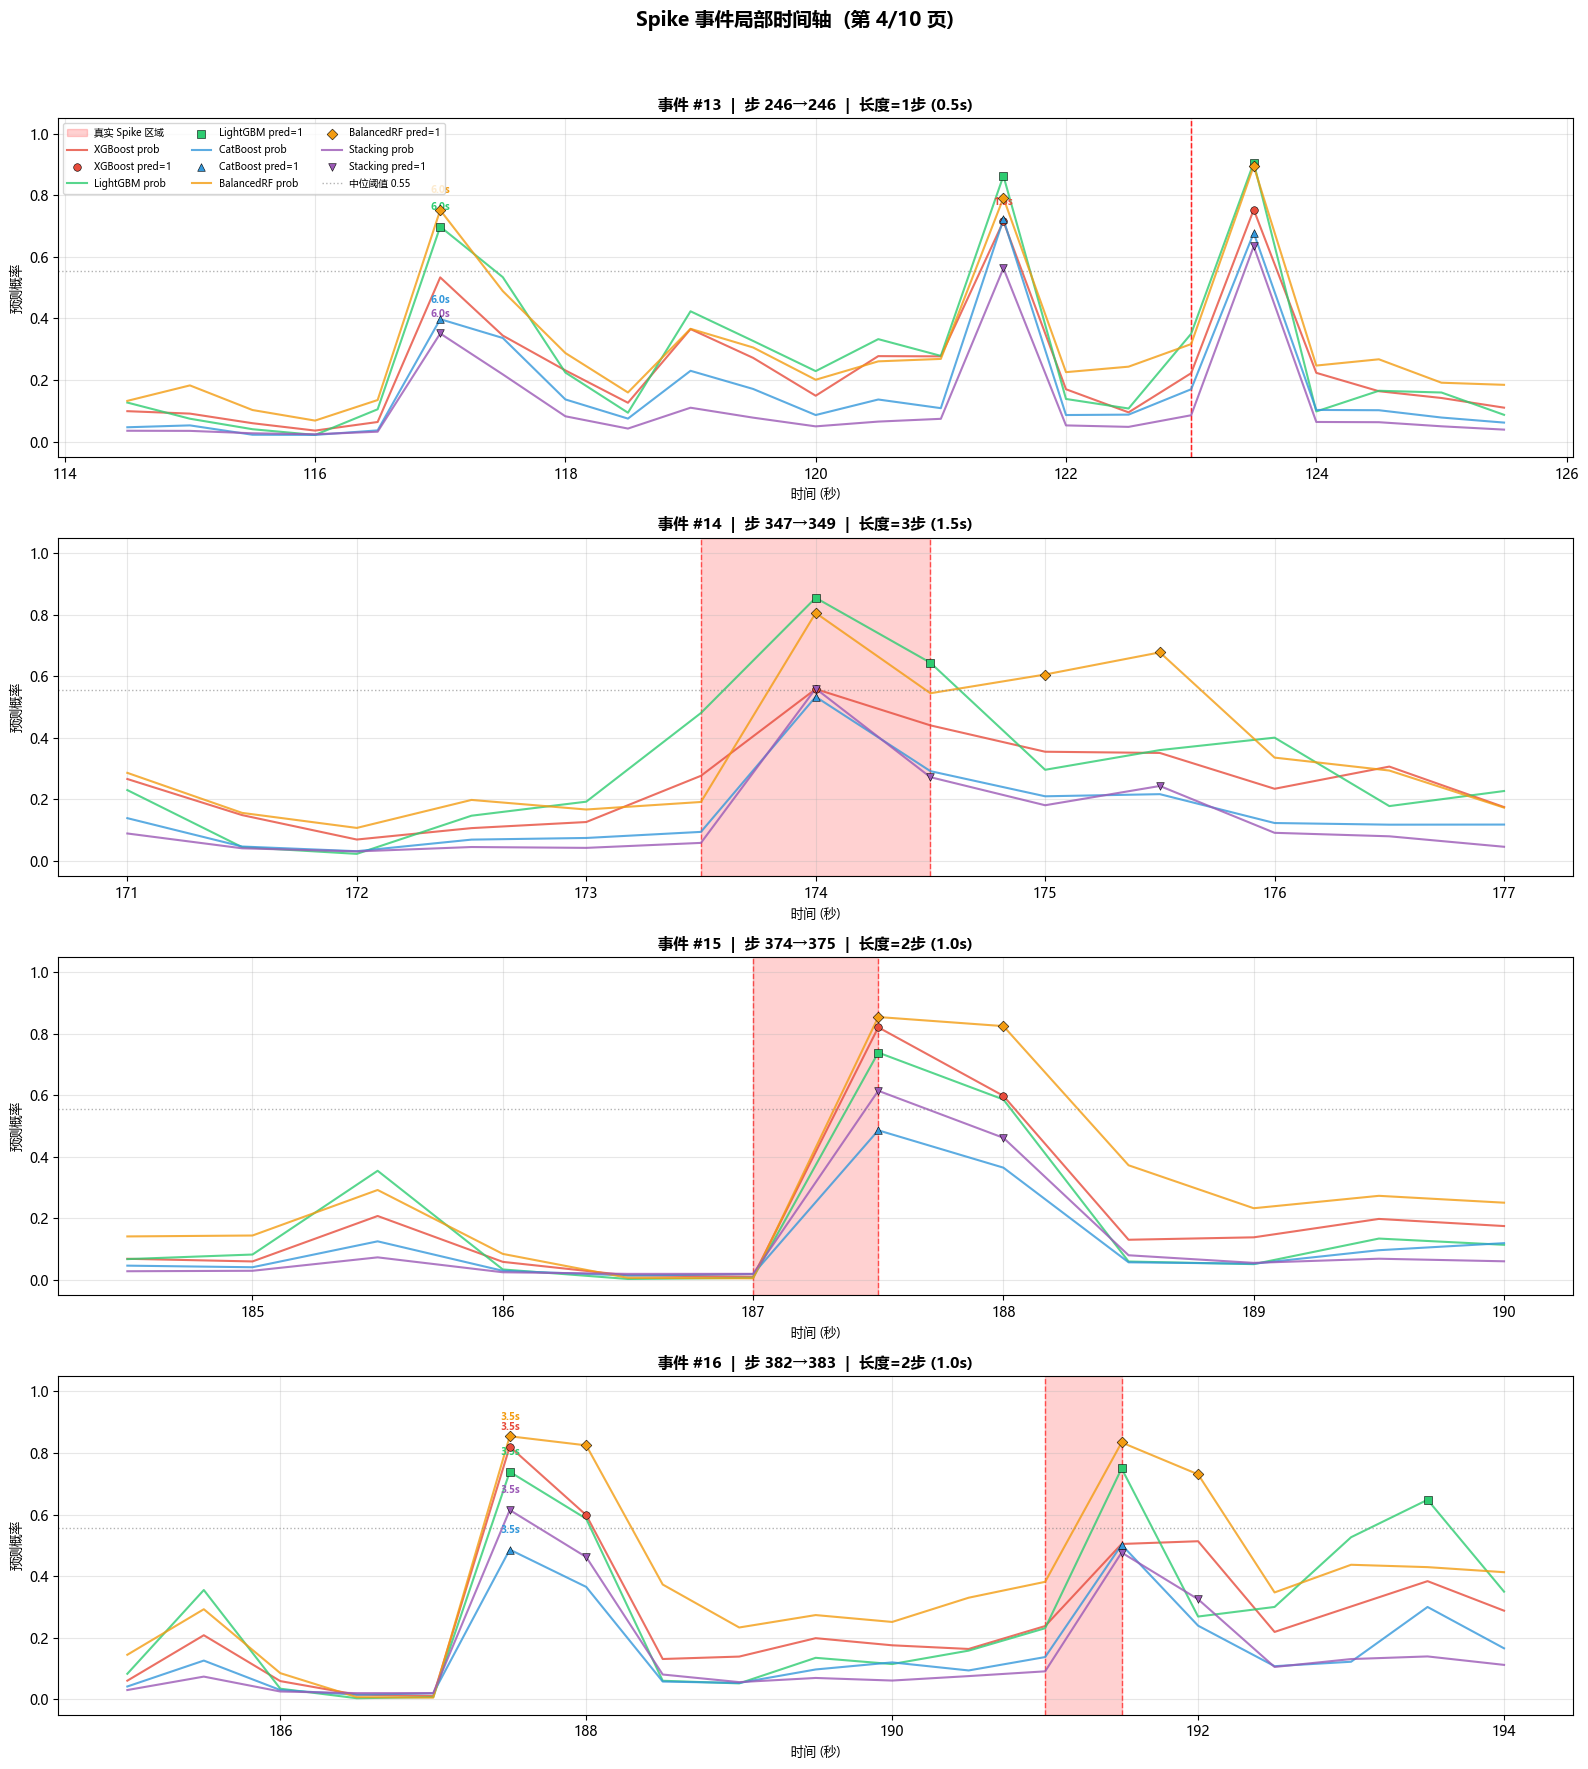

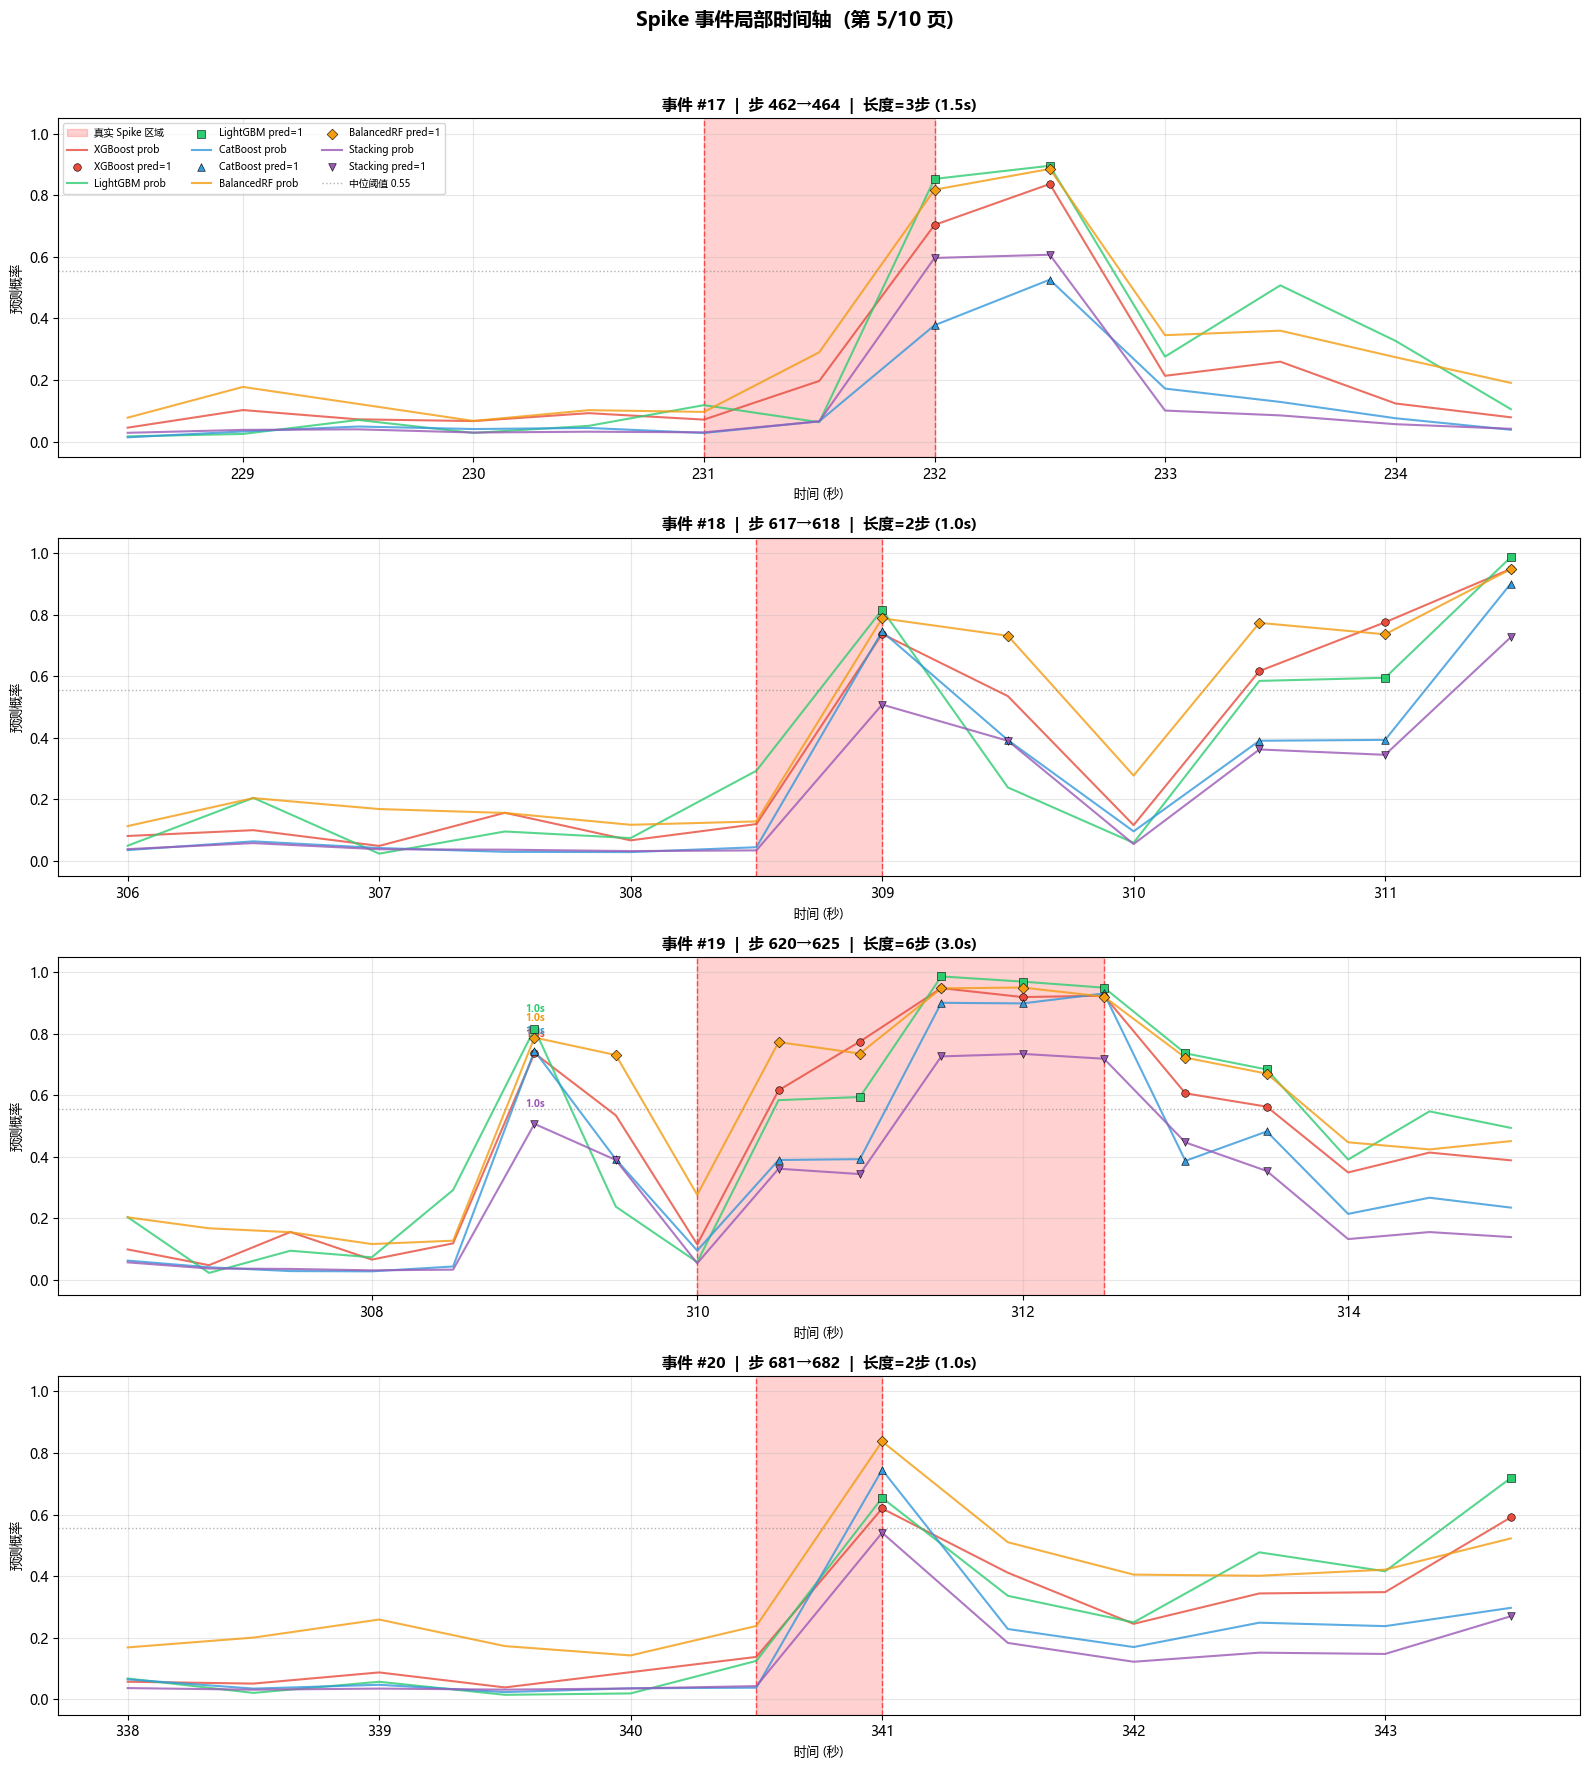

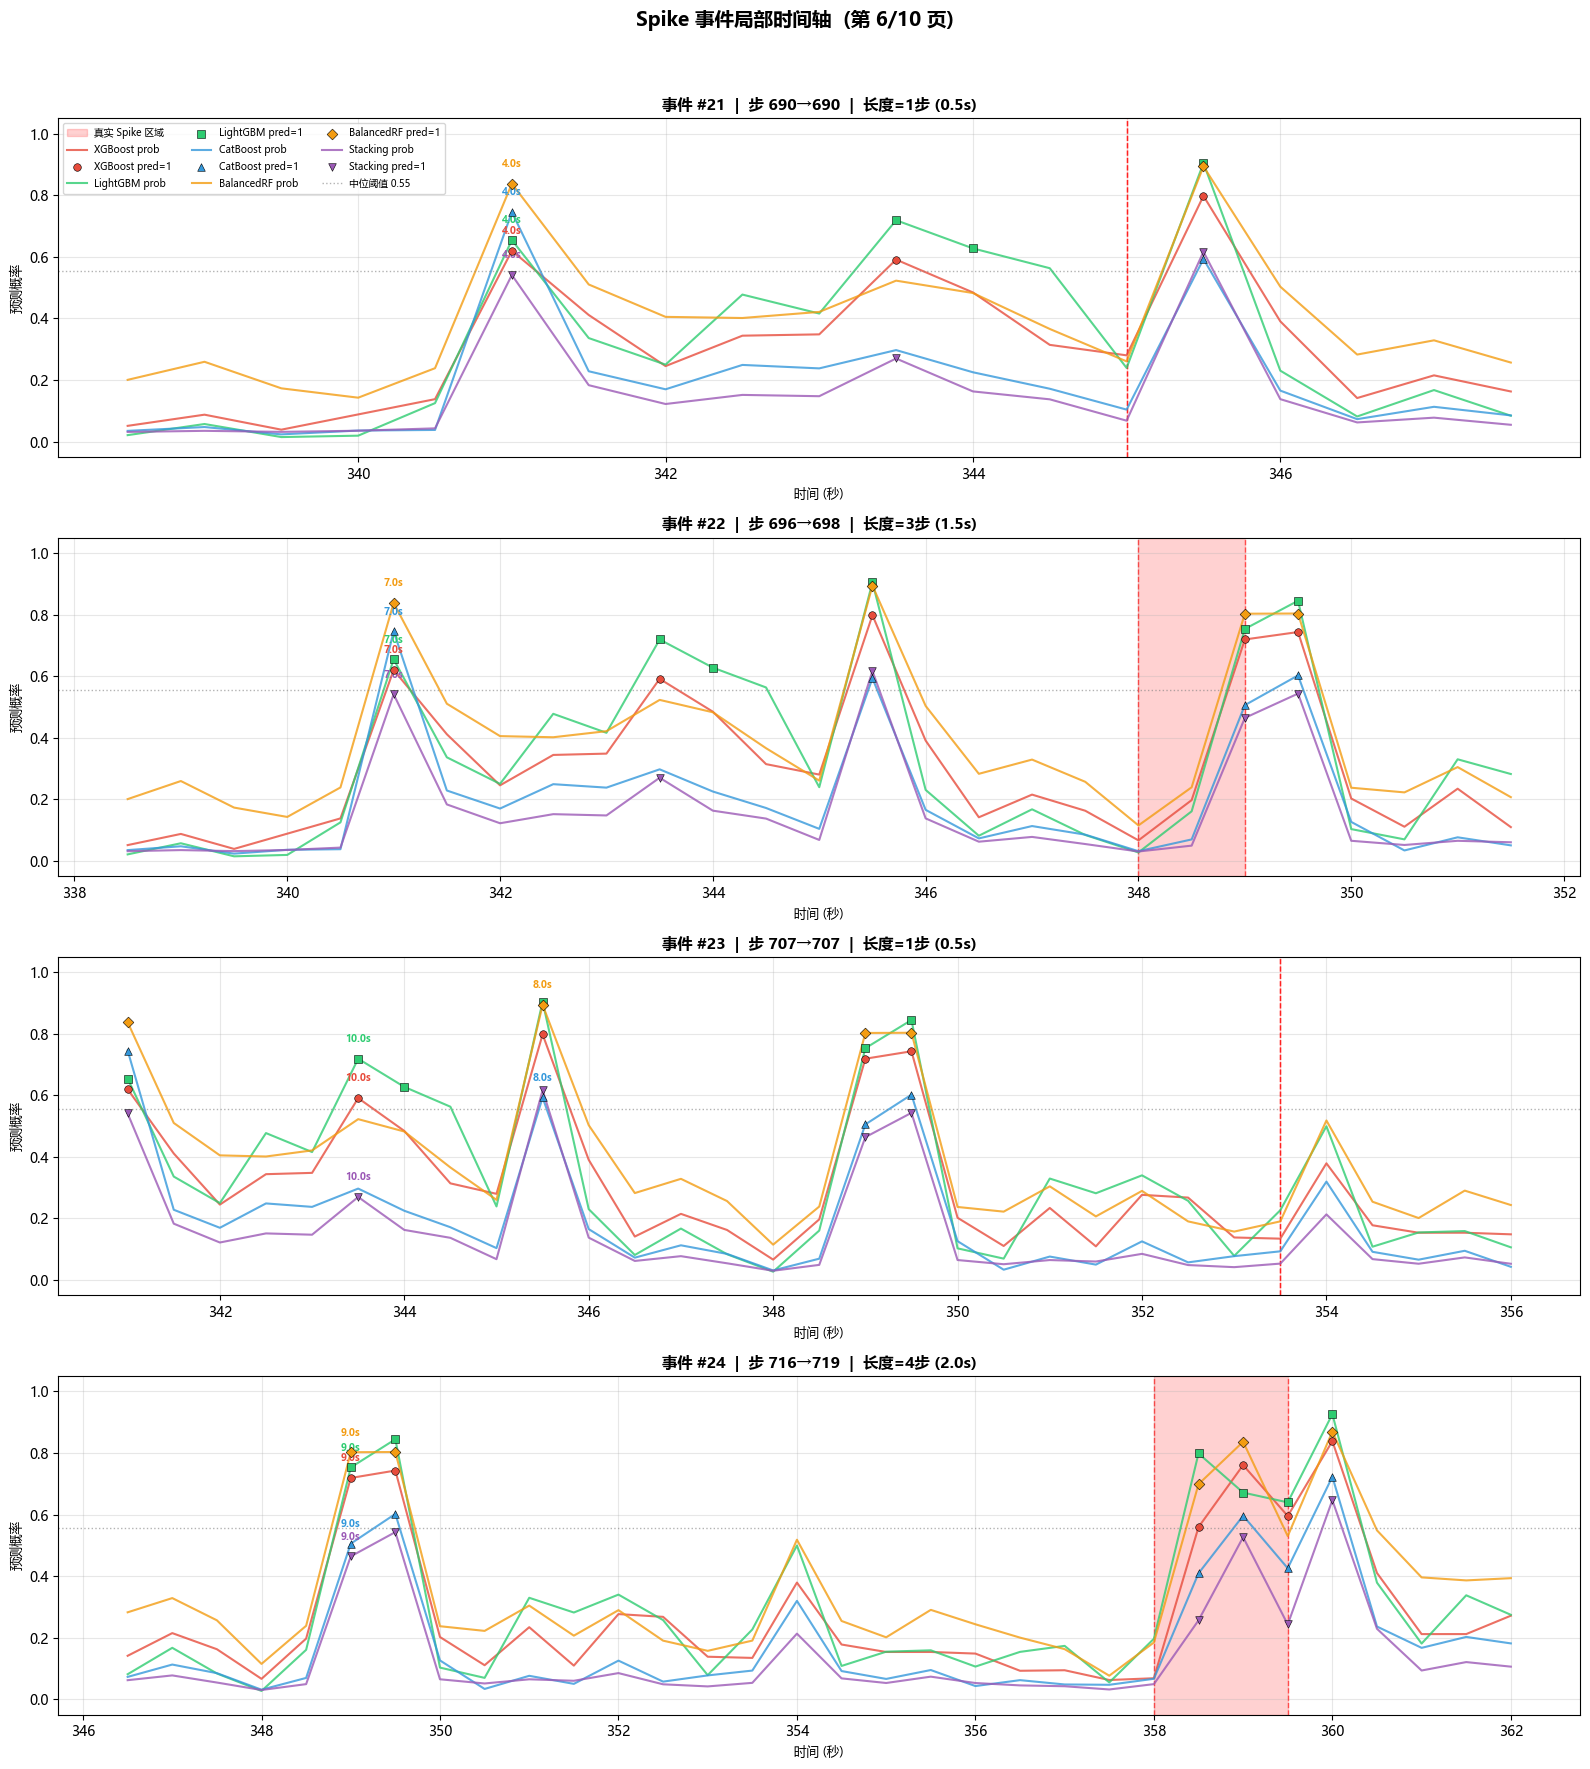

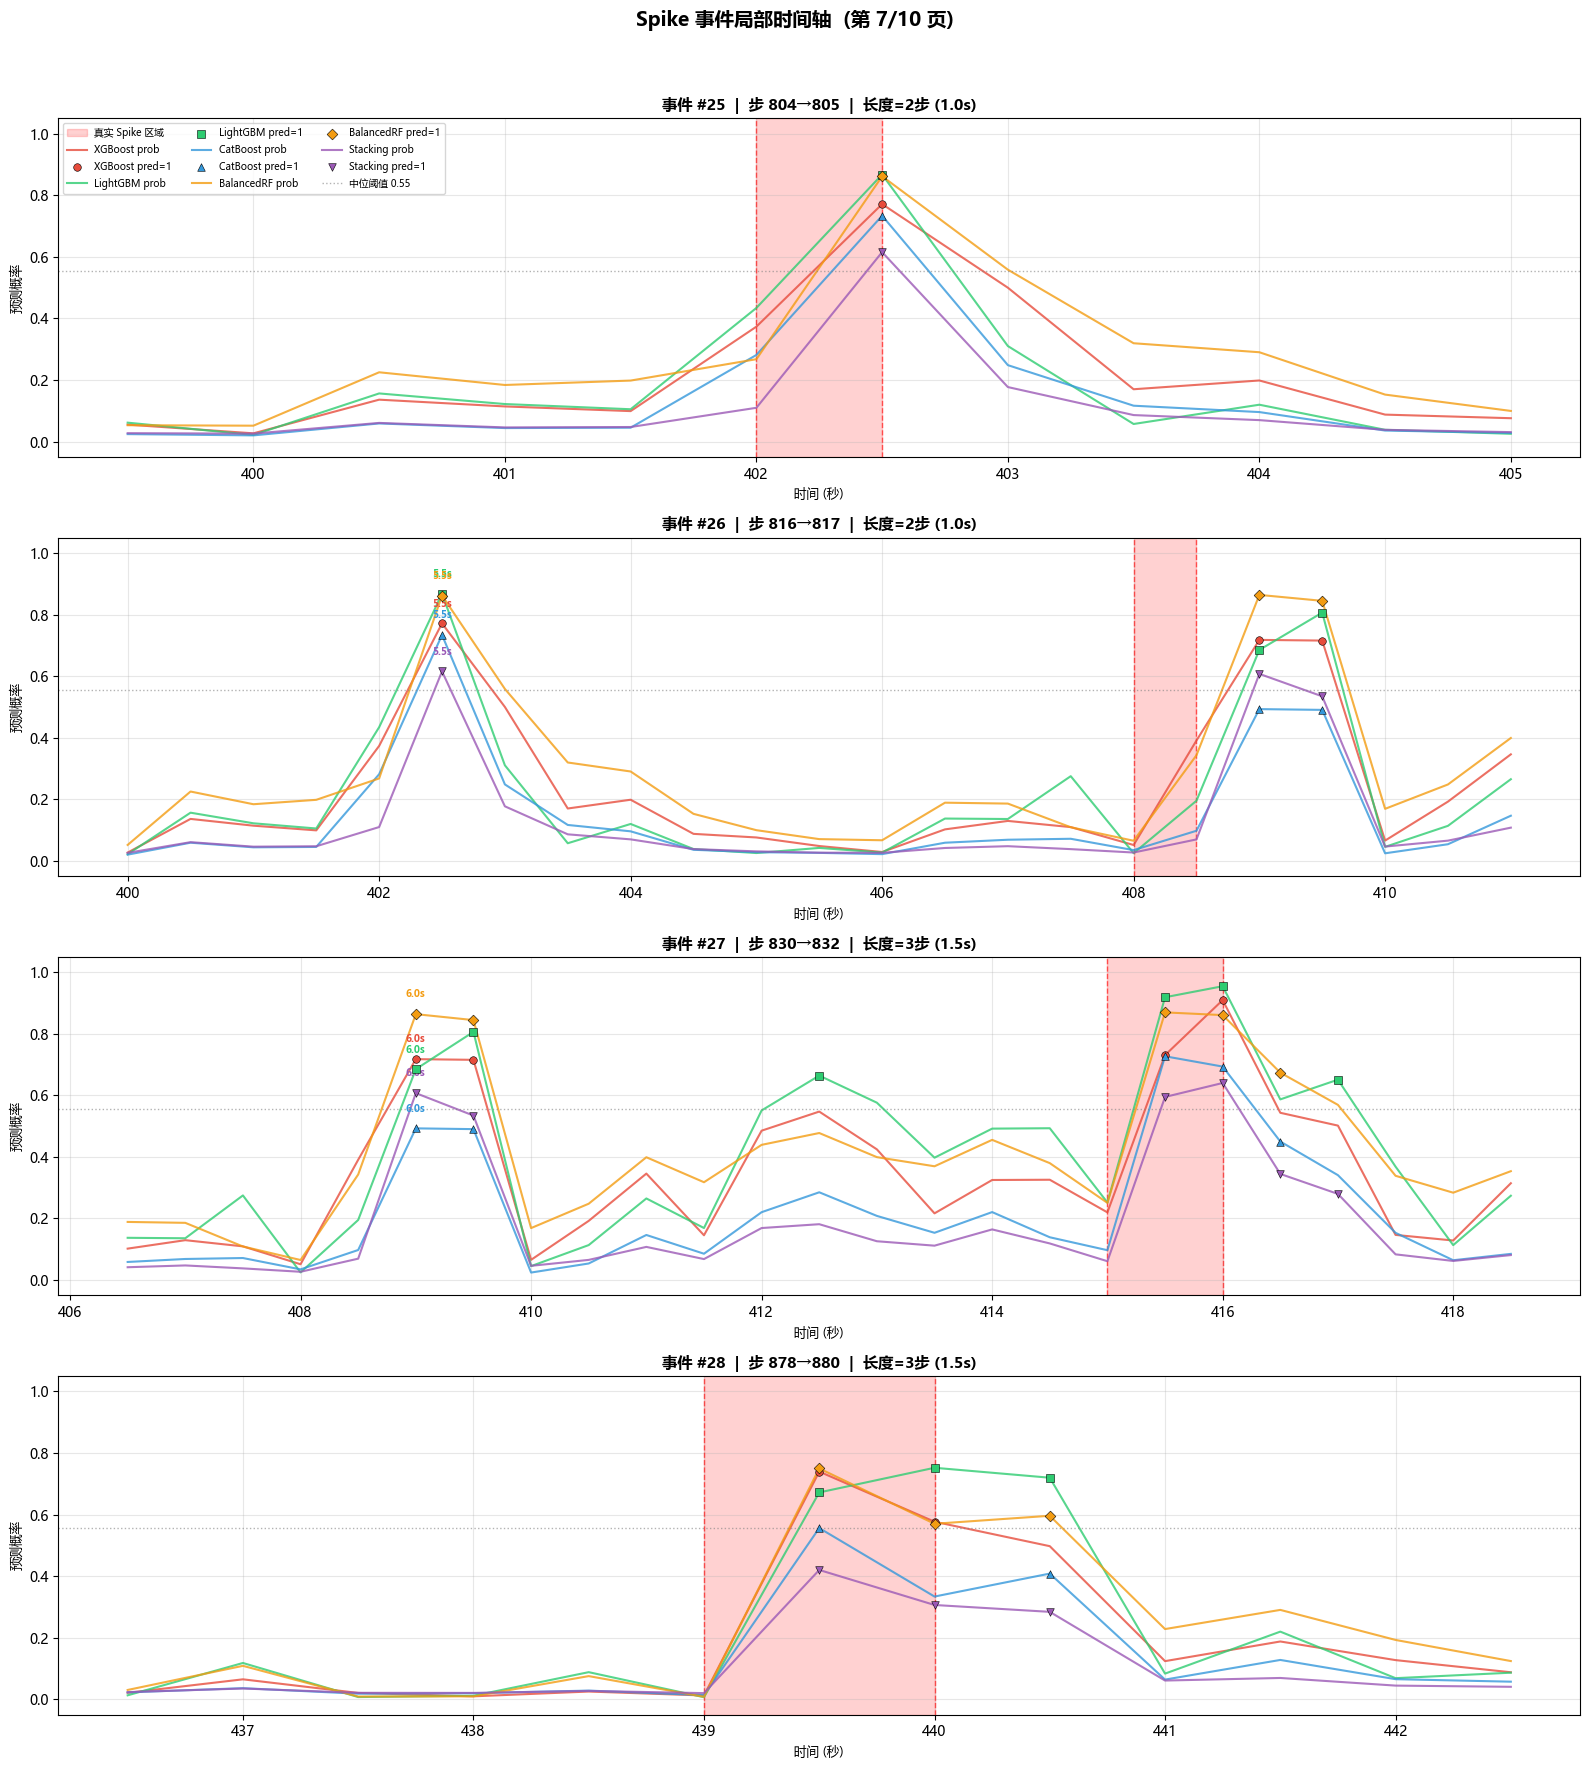

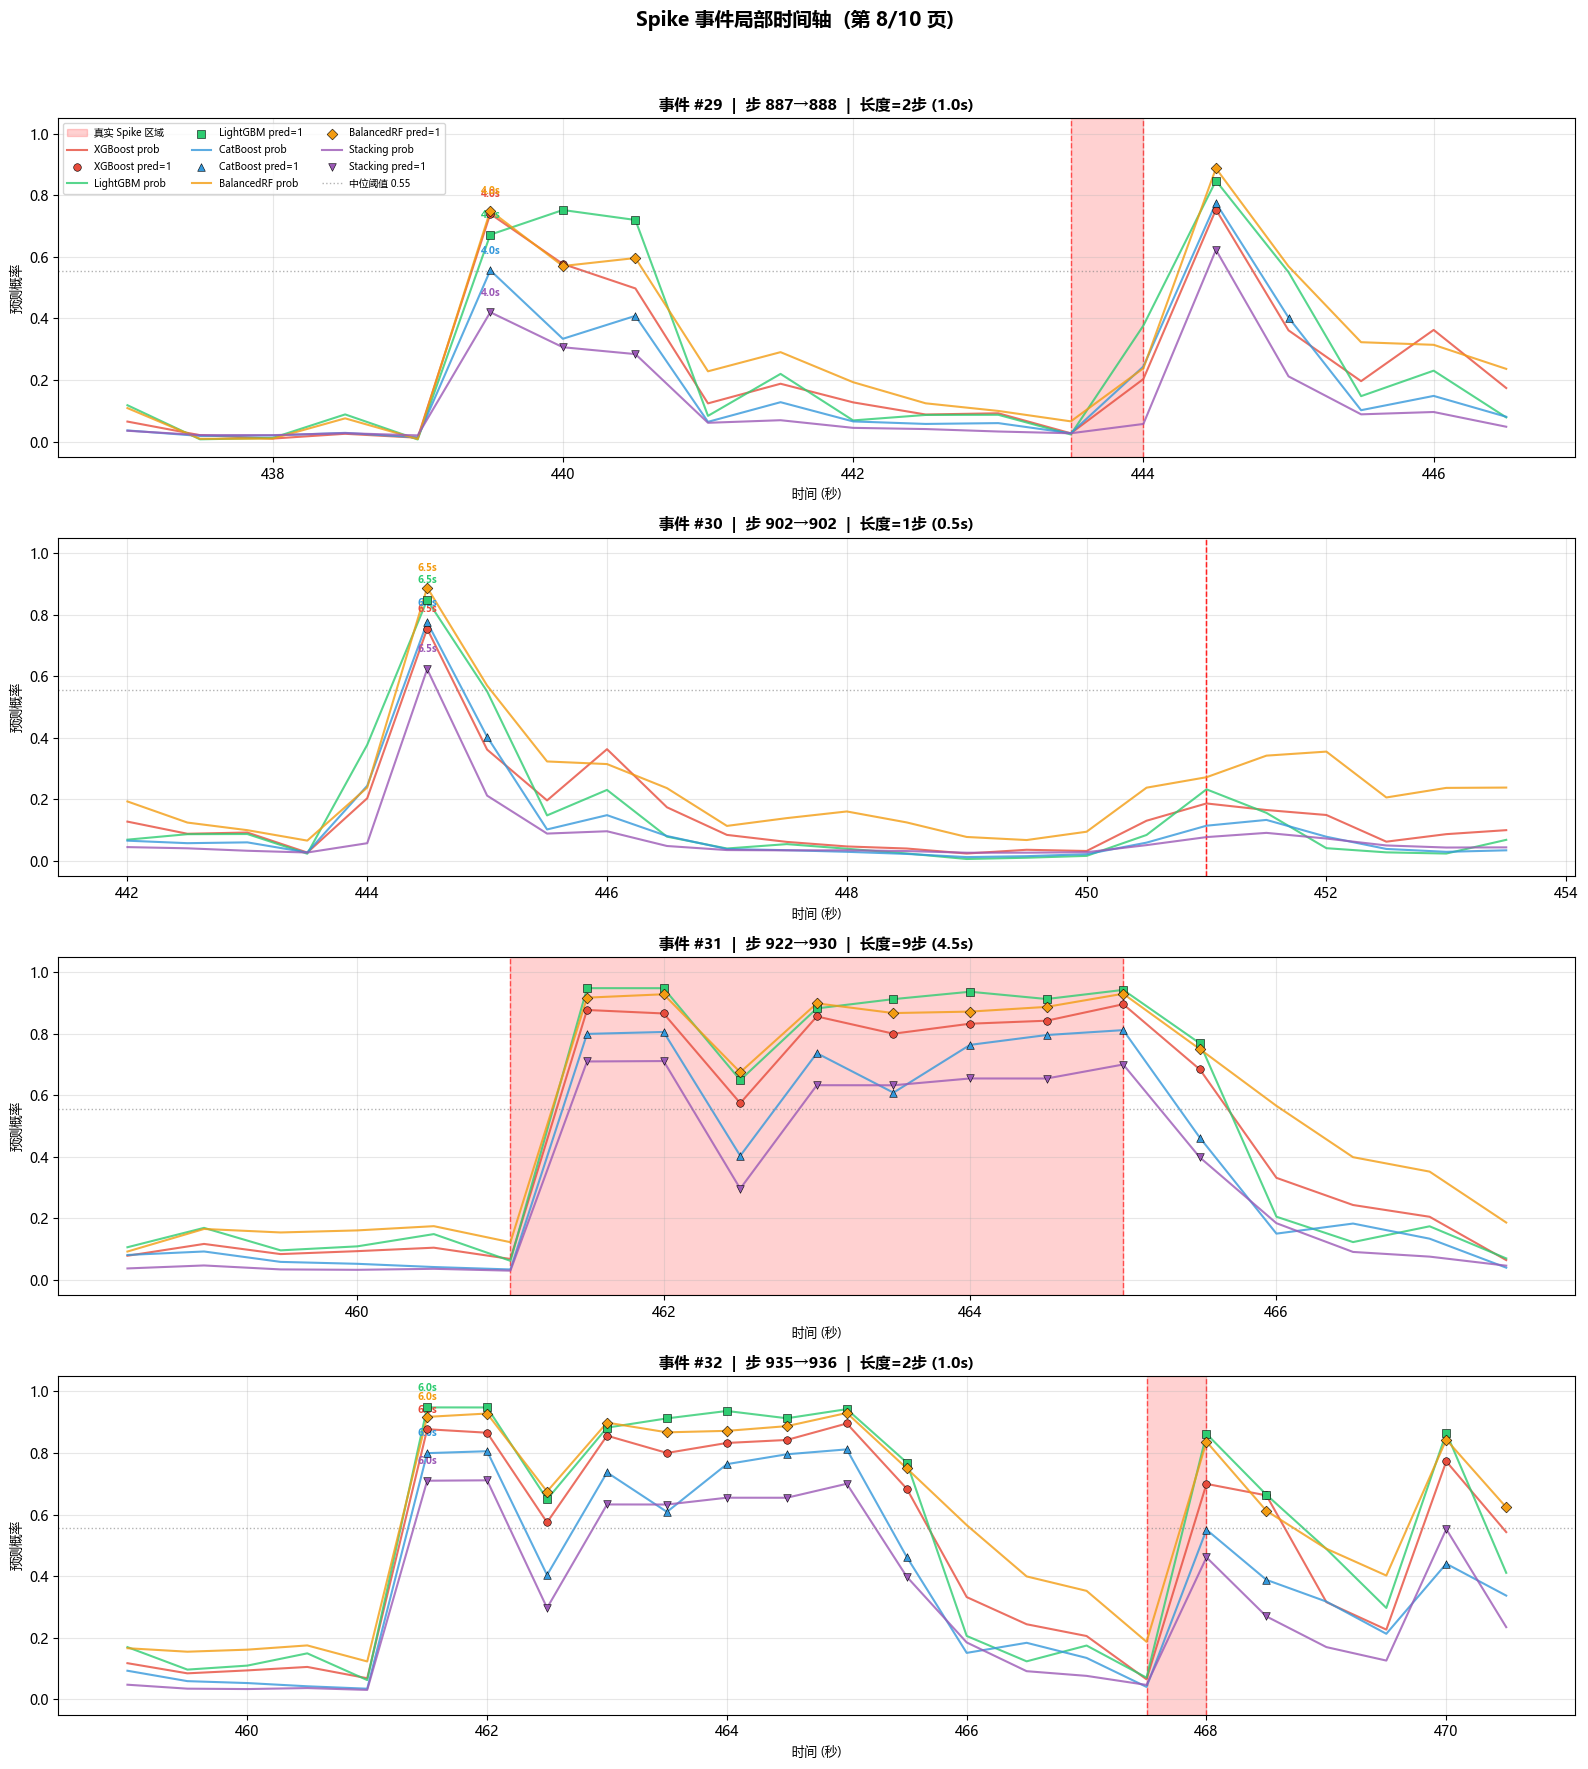

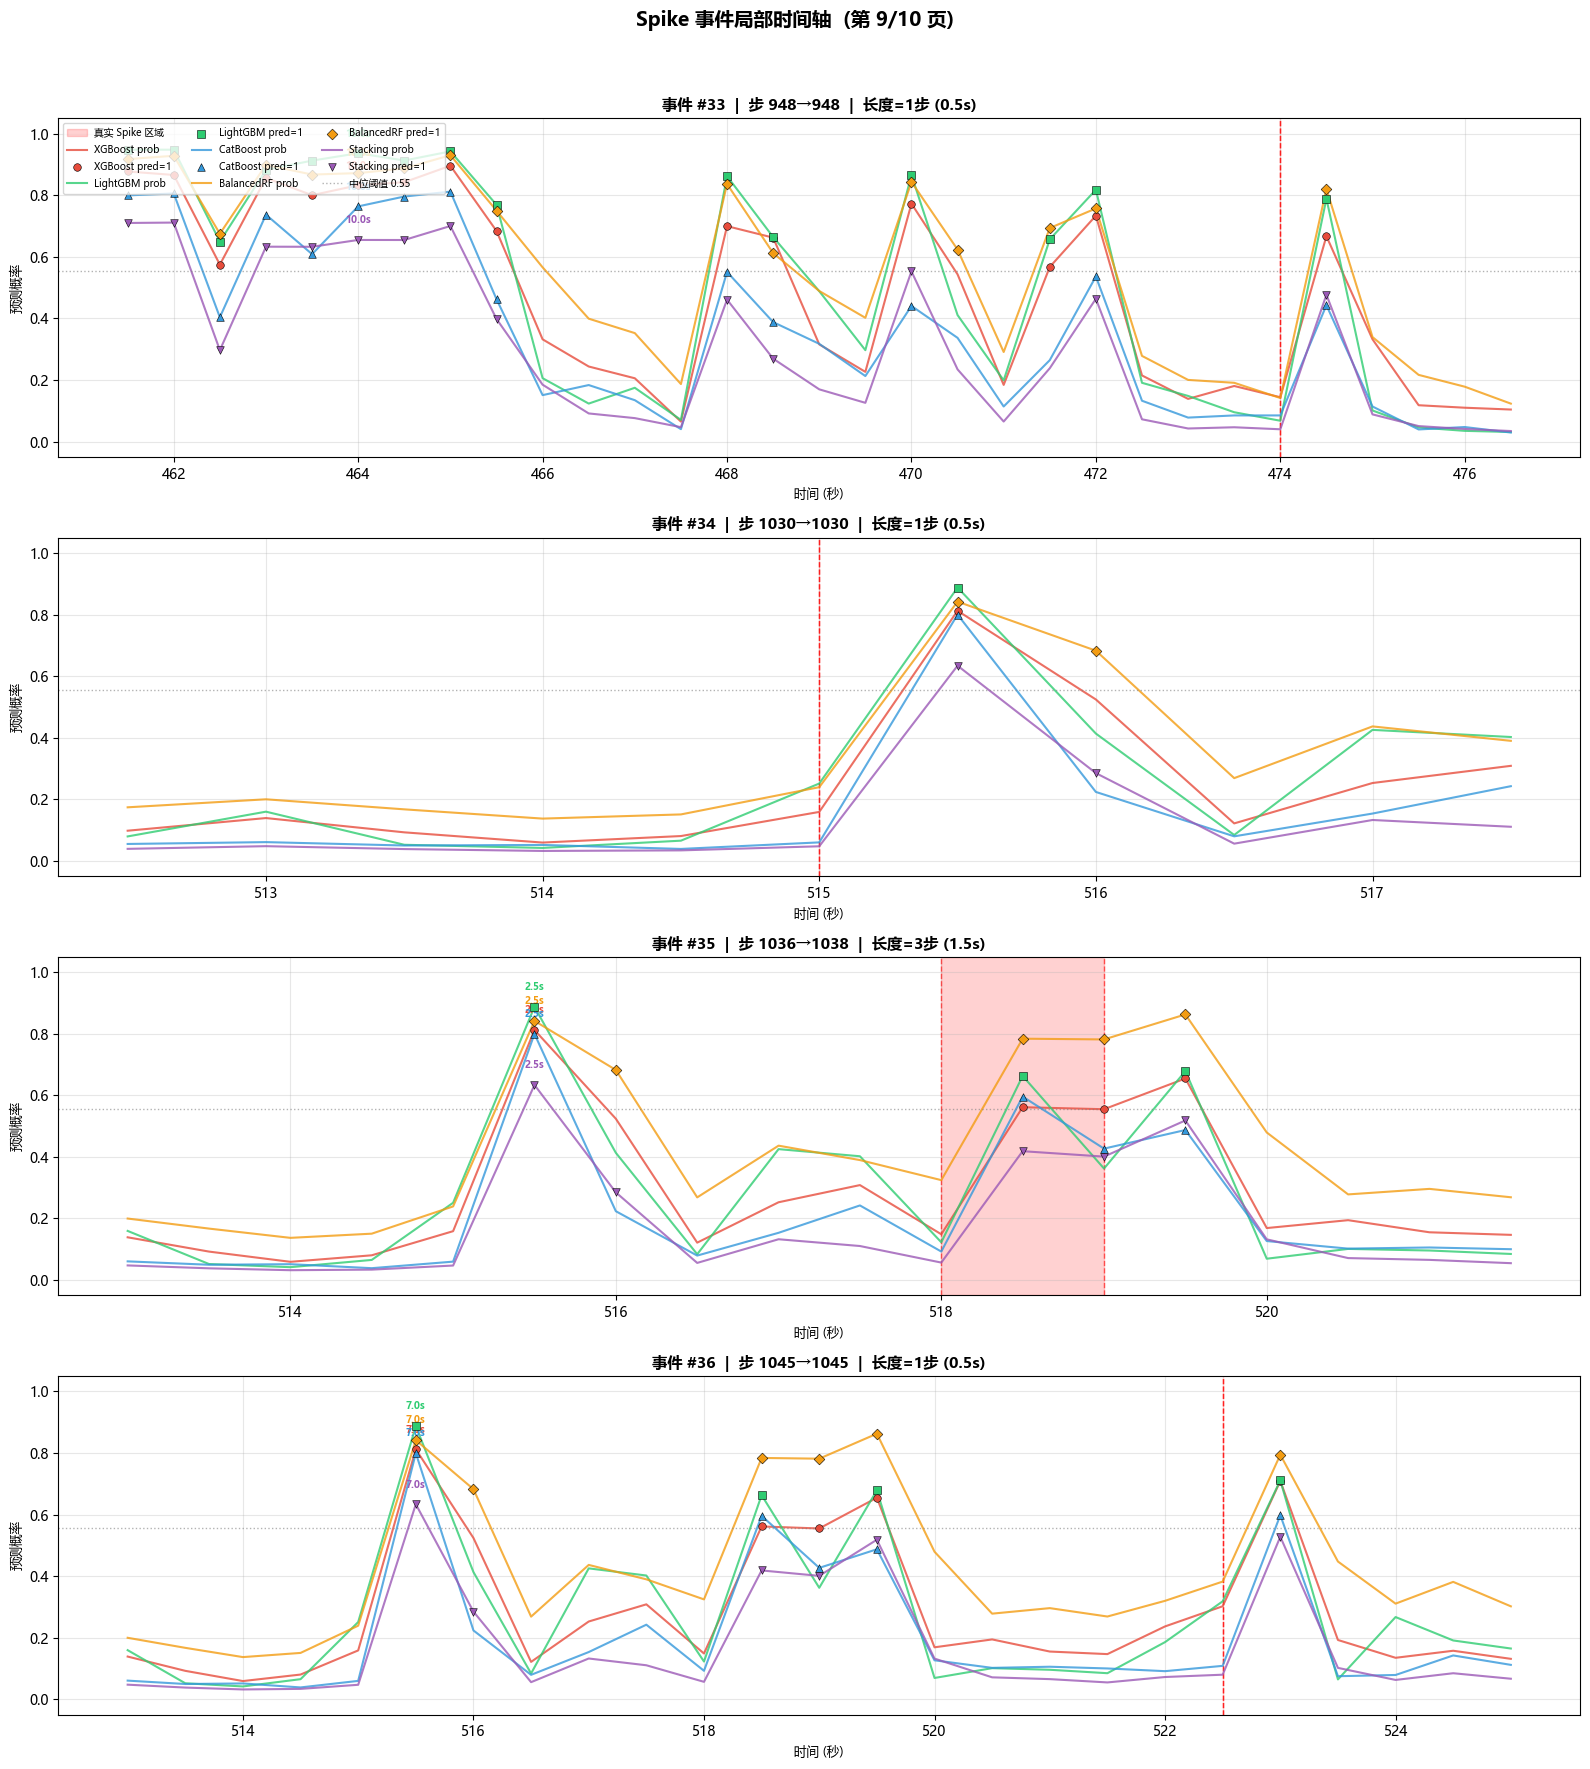

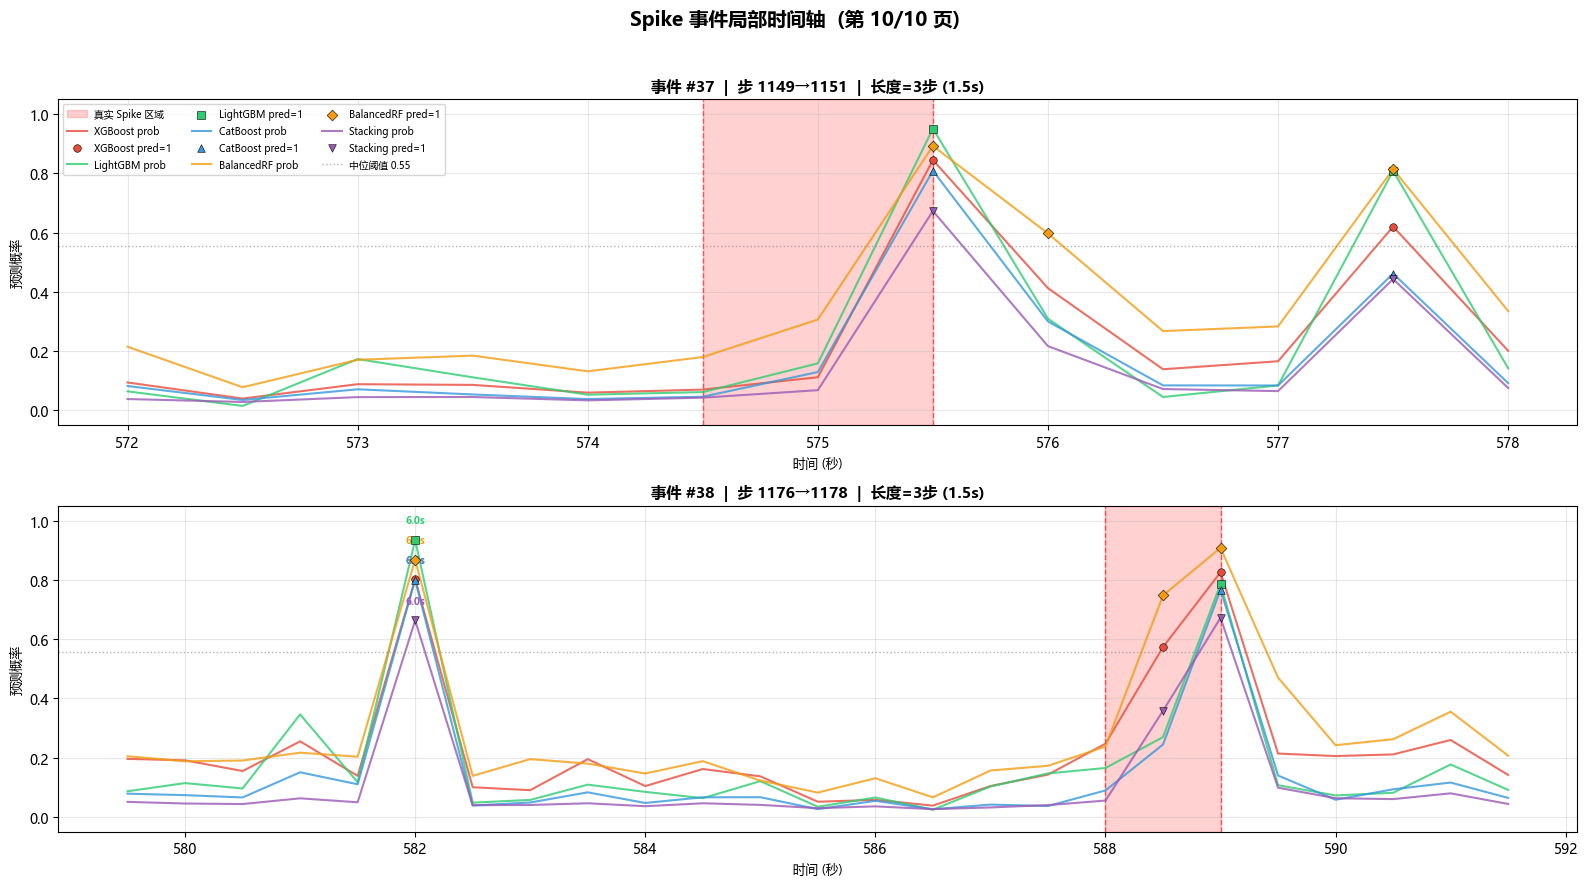


✅ 全部 38 个事件可视化完成


In [20]:
# ==================== 逐事件详细局部时间轴 ====================
# 每个 spike 事件一张子图：从第一次预警到事件结束的局部放大视图
# 显示各模型概率曲线、预测标记、真实 spike 区域

TIME_PER_STEP = 0.5
LOOK_BACK = 20        # 向前搜索预警的步数
MARGIN_BEFORE = 5     # 额外显示事件前 N 步
MARGIN_AFTER = 5      # 额外显示事件后 N 步
EVENTS_PER_PAGE = 4   # 每页子图数

true_seq = y_test.values

# ───── 识别 spike 事件 ─────
events = []
in_event = False
for i in range(len(true_seq)):
    if true_seq[i] == 1 and not in_event:
        event_start = i; in_event = True
    elif true_seq[i] == 0 and in_event:
        events.append((event_start, i - 1)); in_event = False
if in_event:
    events.append((event_start, len(true_seq) - 1))

print(f"共 {len(events)} 个 spike 事件，每页 {EVENTS_PER_PAGE} 个\n")

# 模型颜色 & 标记
model_styles = {
    'XGBoost':    {'color': '#e74c3c', 'marker': 'o'},
    'LightGBM':   {'color': '#2ecc71', 'marker': 's'},
    'CatBoost':   {'color': '#3498db', 'marker': '^'},
    'BalancedRF': {'color': '#f39c12', 'marker': 'D'},
    'Stacking':   {'color': '#9b59b6', 'marker': 'v'},
}

# ───── 分页绘制 ─────
n_pages = int(np.ceil(len(events) / EVENTS_PER_PAGE))

for page in range(n_pages):
    page_events = events[page * EVENTS_PER_PAGE : (page + 1) * EVENTS_PER_PAGE]
    n_sub = len(page_events)

    fig, axes = plt.subplots(n_sub, 1, figsize=(16, 4.5 * n_sub), squeeze=False)

    for idx, (start, end) in enumerate(page_events):
        event_id = page * EVENTS_PER_PAGE + idx + 1
        ax = axes[idx, 0]

        # 确定可视化窗口
        # 找所有模型中最早的预警信号
        earliest_warning = start
        for mname, r in results.items():
            search_start = max(0, start - LOOK_BACK)
            for j in range(search_start, start):
                if r['pred'][j] == 1:
                    earliest_warning = min(earliest_warning, j)
                    break

        win_start = max(0, min(earliest_warning, start) - MARGIN_BEFORE)
        win_end = min(len(true_seq) - 1, end + MARGIN_AFTER)

        x_steps = np.arange(win_start, win_end + 1)
        x_time = x_steps * TIME_PER_STEP  # 转换为秒

        # 1) 真实 spike 区域 (阴影)
        spike_start_t = start * TIME_PER_STEP
        spike_end_t = end * TIME_PER_STEP
        ax.axvspan(spike_start_t, spike_end_t, alpha=0.18, color='red', label='真实 Spike 区域')

        # 虚线标注 spike 起止
        ax.axvline(spike_start_t, color='red', ls='--', alpha=0.6, lw=1)
        ax.axvline(spike_end_t, color='red', ls='--', alpha=0.6, lw=1)

        # 2) 各模型概率曲线 + 预测=1 的散点
        for mname, r in results.items():
            sty = model_styles.get(mname, {'color': 'gray', 'marker': 'x'})
            prob_slice = r['prob'][win_start:win_end + 1]
            pred_slice = r['pred'][win_start:win_end + 1]

            # 概率曲线
            ax.plot(x_time, prob_slice, color=sty['color'], alpha=0.8, lw=1.5, label=f'{mname} prob')

            # 预测=1 的点
            pred_mask = pred_slice == 1
            if pred_mask.any():
                ax.scatter(x_time[pred_mask], prob_slice[pred_mask],
                          color=sty['color'], marker=sty['marker'], s=30,
                          edgecolors='black', linewidths=0.4, zorder=5,
                          label=f'{mname} pred=1')

        # 3) 阈值线 (取各模型阈值的中位数作为参考)
        thresholds = [r['threshold'] for r in results.values()]
        median_thr = np.median(thresholds)
        ax.axhline(median_thr, color='gray', ls=':', alpha=0.6, lw=1,
                   label=f'中位阈值 {median_thr:.2f}')

        # 4) 标注提前预警秒数 (首信号)
        for mname, r in results.items():
            search_start = max(0, start - LOOK_BACK)
            first_j = next((j for j in range(search_start, start) if r['pred'][j] == 1), None)
            if first_j is not None:
                lead_s = (start - first_j) * TIME_PER_STEP
                t_first = first_j * TIME_PER_STEP
                sty = model_styles.get(mname, {'color': 'gray'})
                ax.annotate(f'{lead_s:.1f}s',
                           xy=(t_first, r['prob'][first_j]),
                           xytext=(0, 12), textcoords='offset points',
                           fontsize=7, color=sty['color'], fontweight='bold',
                           ha='center')

        # 装饰
        event_len = end - start + 1
        ax.set_title(f'事件 #{event_id}  |  步 {start}→{end}  |  '
                     f'长度={event_len}步 ({event_len*TIME_PER_STEP:.1f}s)',
                     fontsize=11, fontweight='bold')
        ax.set_xlabel('时间 (秒)', fontsize=9)
        ax.set_ylabel('预测概率', fontsize=9)
        ax.set_ylim(-0.05, 1.05)
        ax.grid(True, alpha=0.3)

        # 图例只在第一个子图显示
        if idx == 0:
            ax.legend(loc='upper left', fontsize=7, ncol=3, framealpha=0.8)

    fig.suptitle(f'Spike 事件局部时间轴  (第 {page+1}/{n_pages} 页)', fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

print(f"\n✅ 全部 {len(events)} 个事件可视化完成")

In [15]:
# ==================== 导出最优模型 ====================
import json, os

os.makedirs("../model", exist_ok=True)

# 找 PR-AUC 最高的单模型
best_single = max(
    {k: v for k, v in results.items() if k != 'Stacking'},
    key=lambda n: results[n]['pr_auc']
)
best_overall = max(results, key=lambda n: results[n]['pr_auc'])

print(f"最优单模型: {best_single}  PR-AUC={results[best_single]['pr_auc']:.4f}")
print(f"最优整体:   {best_overall}  PR-AUC={results[best_overall]['pr_auc']:.4f}")

# 保存最优单模型
if best_single == 'XGBoost':
    model_xgb.save_model("../model/best_spike_model.json")
    model_xgb.save_model("../model/best_spike_model.bin")
elif best_single == 'LightGBM':
    model_lgbm.booster_.save_model("../model/best_spike_model.txt")
elif best_single == 'CatBoost':
    model_cat.save_model("../model/best_spike_model.cbm")
elif best_single == 'BalancedRF':
    import joblib
    joblib.dump(model_brf, "../model/best_spike_model.pkl")

# 保存元数据
meta = {
    'best_single_model': best_single,
    'best_overall_model': best_overall,
    'feature_cols': feature_cols,
    'spike_threshold_us': THRESHOLD,
    'all_results': {
        name: {
            'pr_auc': float(r['pr_auc']),
            'roc_auc': float(r['roc_auc']),
            'f1': float(r['f1']),
            'precision': float(r['precision']),
            'recall': float(r['recall']),
            'decision_threshold': float(r['threshold']),
        }
        for name, r in results.items()
    },
    'optuna_best_params': {
        'XGBoost': study_xgb.best_params,
        'LightGBM': study_lgbm.best_params,
        'CatBoost': study_cat.best_params,
        'BalancedRF': study_brf.best_params,
    },
    'stacking_meta_coefs': dict(zip(models.keys(), meta_model.coef_[0].tolist())),
}

with open("../model/model_comparison_meta.json", "w") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print(f"\n模型和元数据已保存到 model/ 目录")
print(f"\n--- 最终排名 ---")
for rank, (name, _) in enumerate(sorted(results.items(), key=lambda x: -x[1]['pr_auc']), 1):
    r = results[name]
    print(f"  #{rank} {name:<16} PR-AUC={r['pr_auc']:.4f}  F1={r['f1']:.4f}")

最优单模型: XGBoost  PR-AUC=0.5217
最优整体:   XGBoost  PR-AUC=0.5217

模型和元数据已保存到 model/ 目录

--- 最终排名 ---
  #1 XGBoost          PR-AUC=0.5217  F1=0.5612
  #2 CatBoost         PR-AUC=0.5199  F1=0.5628
  #3 Stacking         PR-AUC=0.4976  F1=0.5566
  #4 LightGBM         PR-AUC=0.4944  F1=0.5437
  #5 BalancedRF       PR-AUC=0.4934  F1=0.5377
